# Additional figures (hmf metric boxplots by aquifer & huc2, event frequency-duration curves)

In [183]:
# IMPORTS
import os
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
#import contextily as cx
import requests
import calendar
from importlib import reload

from datetime import datetime, timedelta
from shapely.geometry import Point
from io import StringIO
from mpl_toolkits.axes_grid1 import make_axes_locatable

# USGS Data retreival tool
from dataretrieval import nwis, utils, codes

# Custom modules are imported in multiple locations to faciliate easy reloading when edits are made to their respective files
import Src.classes as cl
import Src.func_ko as fn
reload(cl)
reload(fn)

<module 'Src.func_ko' from 'C:\\Users\\kondr\\Documents\\GitHub\\HighMagFlows_EPA_Project\\Src\\func_ko.py'>

### Import national metrics

In [184]:
# All gages - National metrics dfs
data_paths = {
    '30_90': 'Prelim_Data/National_Metrics/National_Metrics_30_90.xlsx',
    '50_90': 'Prelim_Data/National_Metrics/National_Metrics_50_90.xlsx',
    '30_95': 'Prelim_Data/National_Metrics/National_Metrics_30_95.xlsx',
    '50_95': 'Prelim_Data/National_Metrics/National_Metrics_50_95.xlsx'    
}

dfs_metrics = {key: pd.read_excel(path, sheet_name='site_metrics') for key, path in data_paths.items()}

In [185]:
# Valid gages - National metrics dfs
date_ranges = ['30', '50']
percentiles = ['90', '95']
dfs_valid = {}
for date_range in date_ranges:
    for percentile in percentiles: 
        dfs_valid[f'{date_range}_{percentile}'] = dfs_metrics[f'{date_range}_{percentile}'][dfs_metrics[f'{date_range}_{percentile}']['valid'] == True]

In [186]:
# Outlet gages by aquifer
br_outlet_gages = ['09520500', '09429600', '09521100', '09519800', '09468500', '09423000', '10327500', '10351650', '10351650', '10311400']
cc_outlet_gages = ['11023000', '11046000', '11078000', '11087020', '11133000', '11140000', '11152500', '11159000', '11467000', '11477000', '11530500', '11532500']
cv_outlet_gages = ['11303500', '11447650']
cl_outlet_gages = ['08211000', '08188500', '08176500', '08164000', '08162000', '08116650', '08066500', '08033500', '08068000', '08030500',
      '08013500', '08012000', '07378500', '02492000', '02489500', '02479000', '02479300', '02469761', '02428400', '02375500']
fl_outlet_gages = ['02368000', '02365500', '02358000', '02320500', '02313230']
hp_outlet_gages = ['08123800', '08121000', '07297910', '07228000', '07234000', '07157500', '07144550', '06853500', '06805500', '06799500', '06465500']
mr_outlet_gages = ['07077000', '07077555', '07047942', '07369000', '07369000', '07285500', '07268000']
na_outlet_gages = ['02105769', '02089500', '02091500', '02083500',  '02085000', '02052000', '02047000', '02049500',  '02041650', '02037500', '01668000', 
      '01673000',  '01646500', '01578310', '01474500',  '01463500']
pn_outlet_gages = ['11039800', '12200500', '12040500', '14211720',  '14372300']
sr_outlet_gages = ['13269000']

outlet_gages_dict = {
    'br': br_outlet_gages, 
    'cc': cc_outlet_gages,
    'cv': cv_outlet_gages,
    'cl': cl_outlet_gages,
    'fl': fl_outlet_gages,
    'hp': hp_outlet_gages,
    'mr': mr_outlet_gages,
    'na': na_outlet_gages,
    'pn': pn_outlet_gages,
    'sr': sr_outlet_gages
}

### Sort by outlet gages

In [187]:
df_outlet_gages = {}
for date_range in date_ranges:
    for percentile in percentiles: 
        df_outlet_gages_aq = {}
        df_temp = dfs_valid[f'{date_range}_{percentile}']

        for key, value in outlet_gages_dict.items():
            df_outlet_gages_aq[key] = df_temp[df_temp['site_no'].isin(value)]
       
        df_outlet_gages[f'{date_range}_{percentile}'] = df_outlet_gages_aq

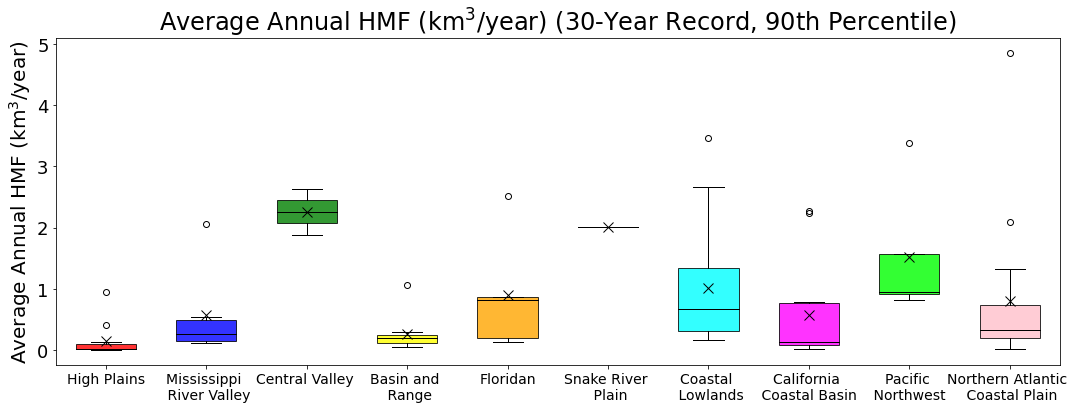

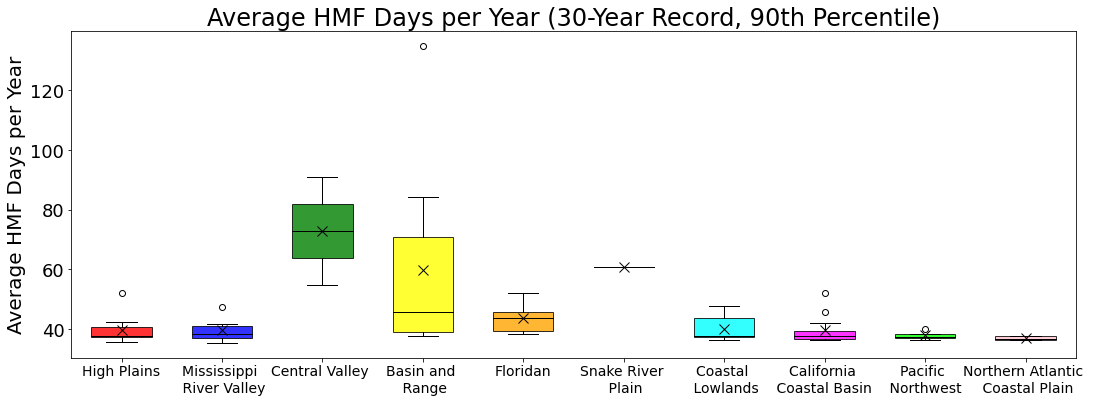

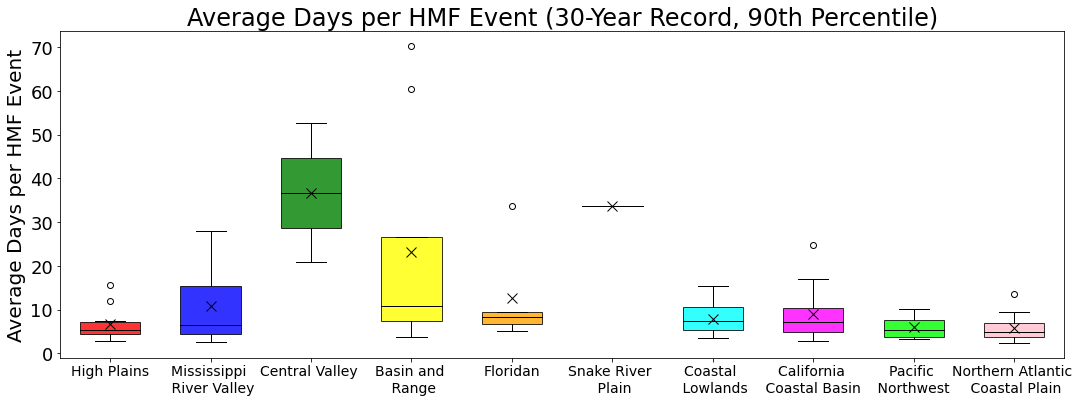

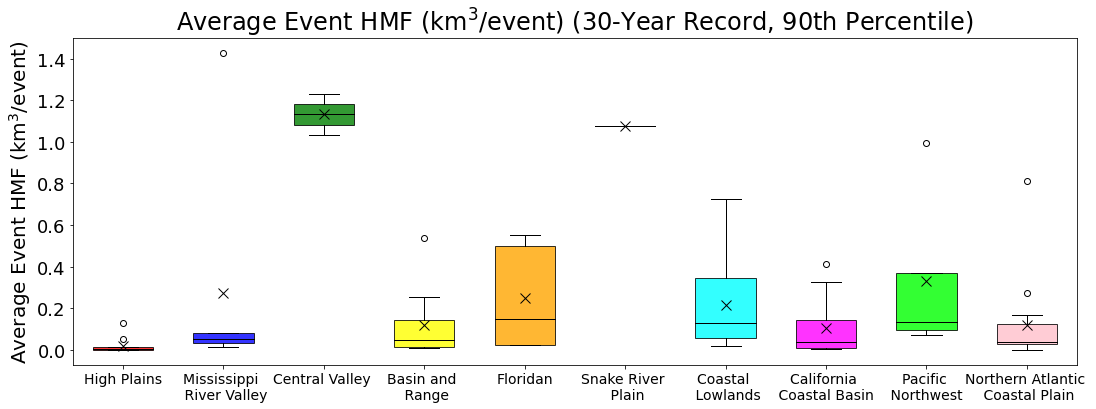

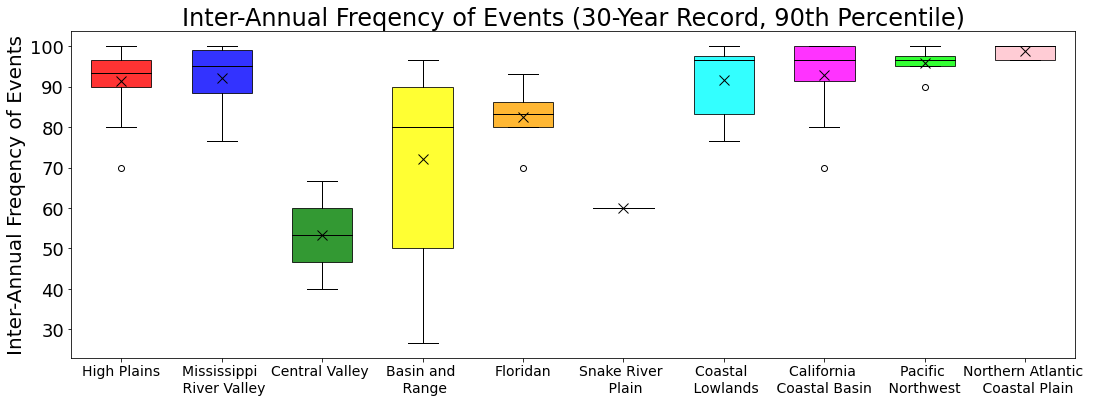

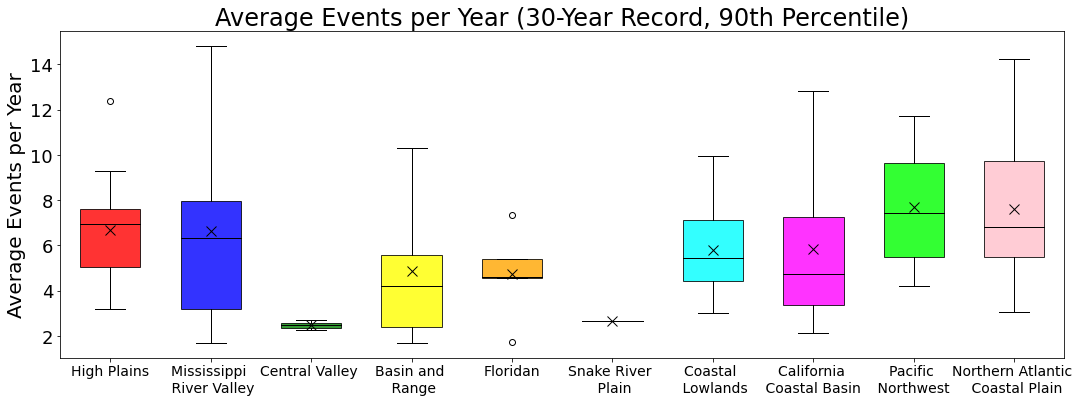

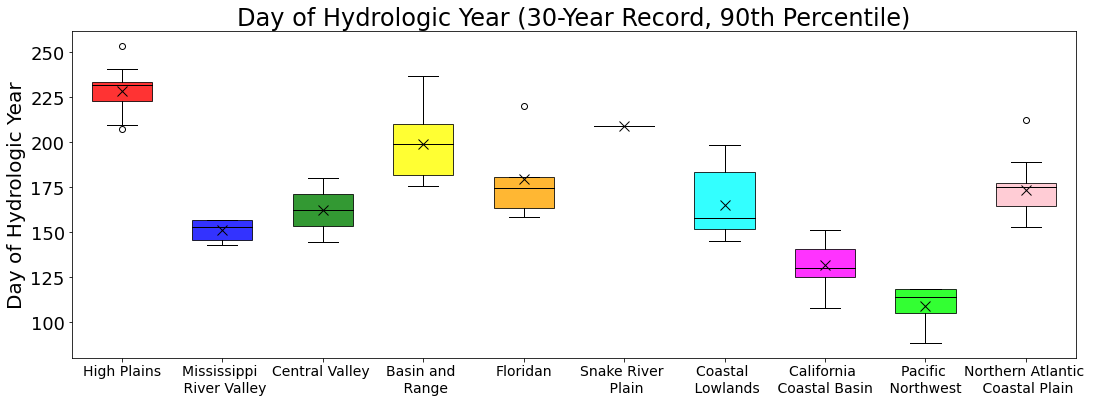

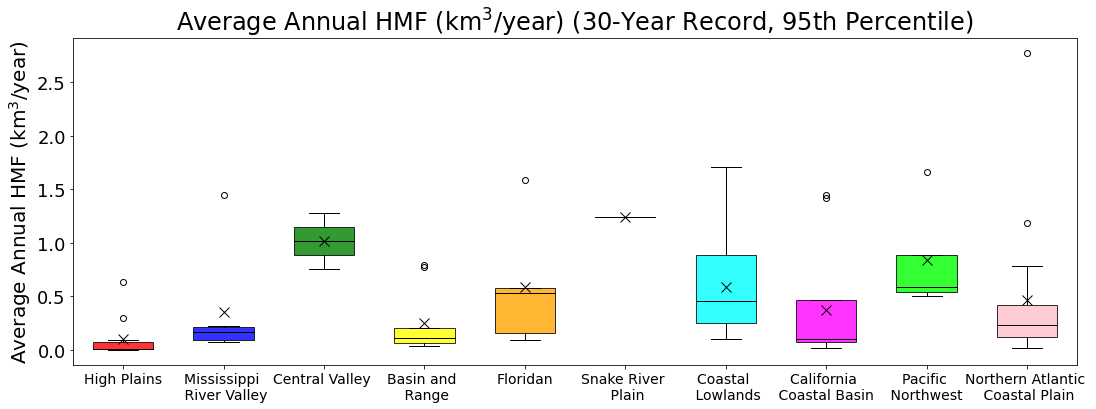

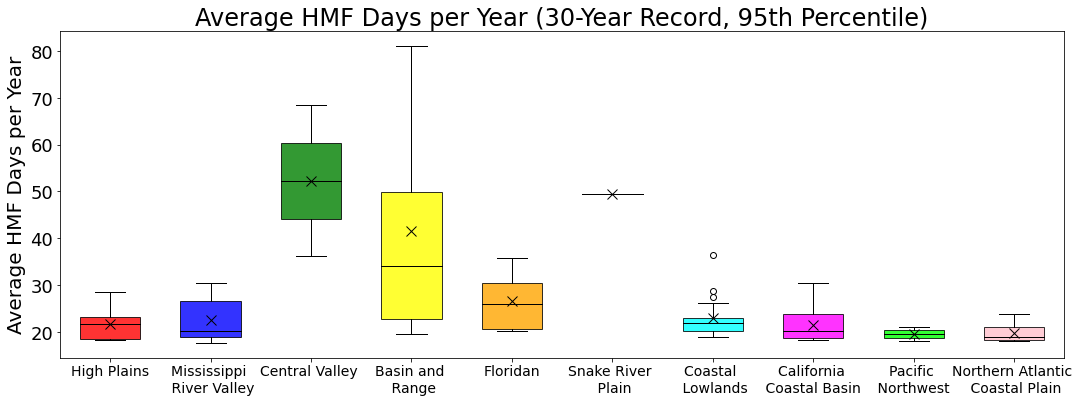

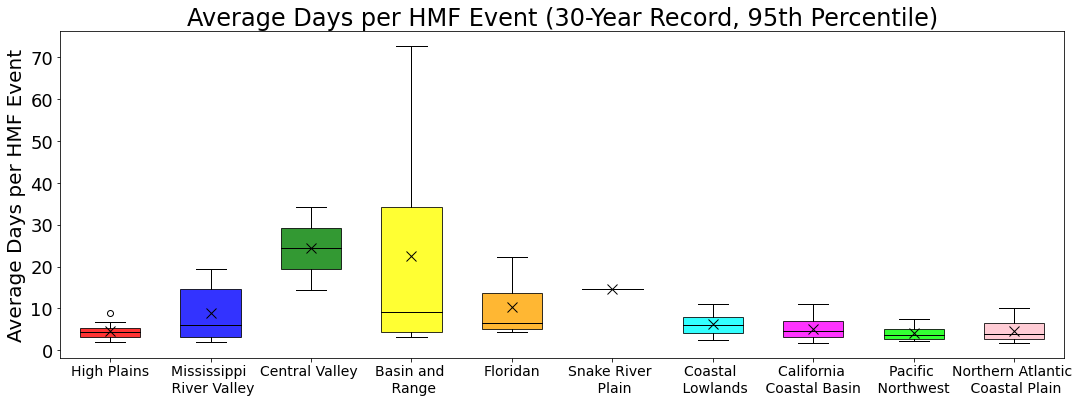

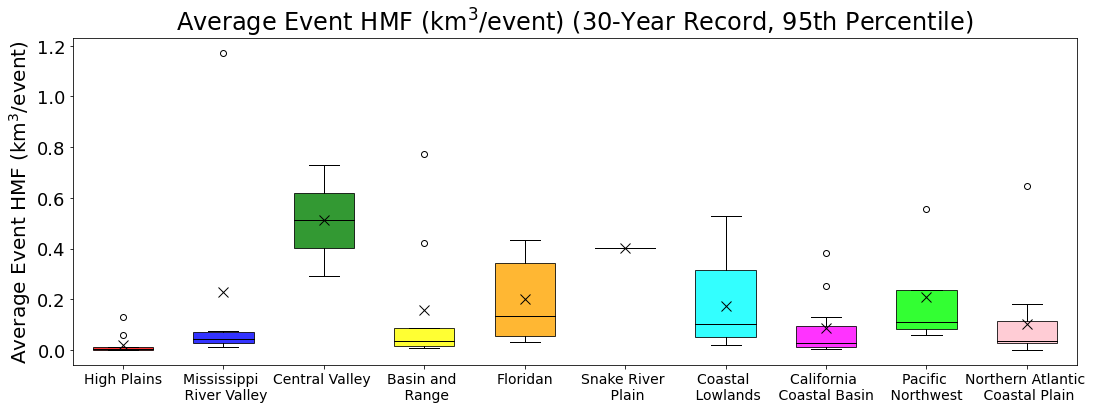

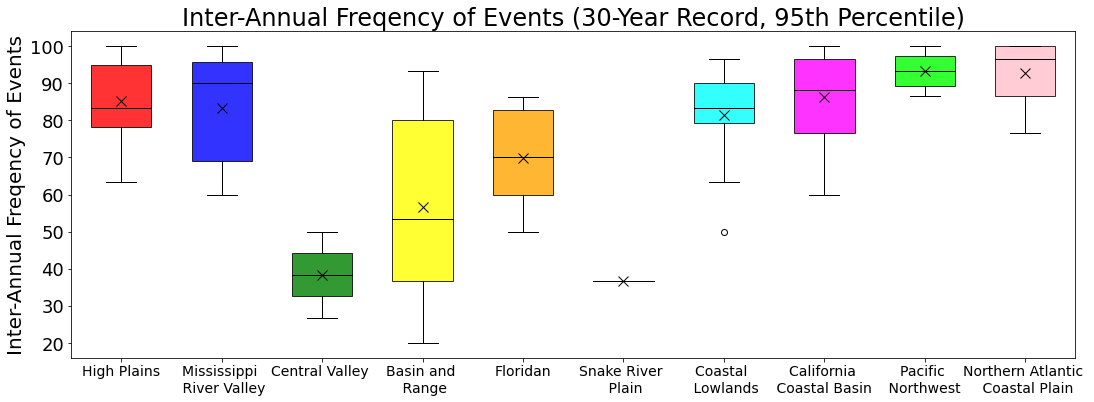

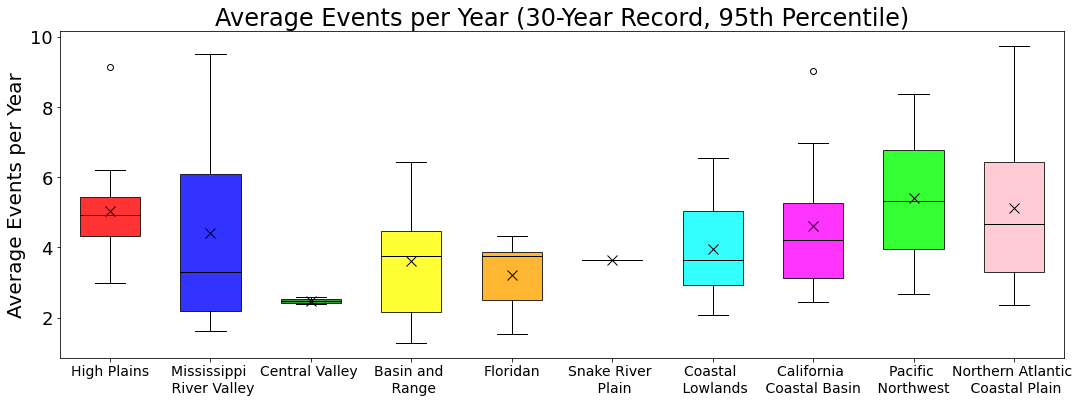

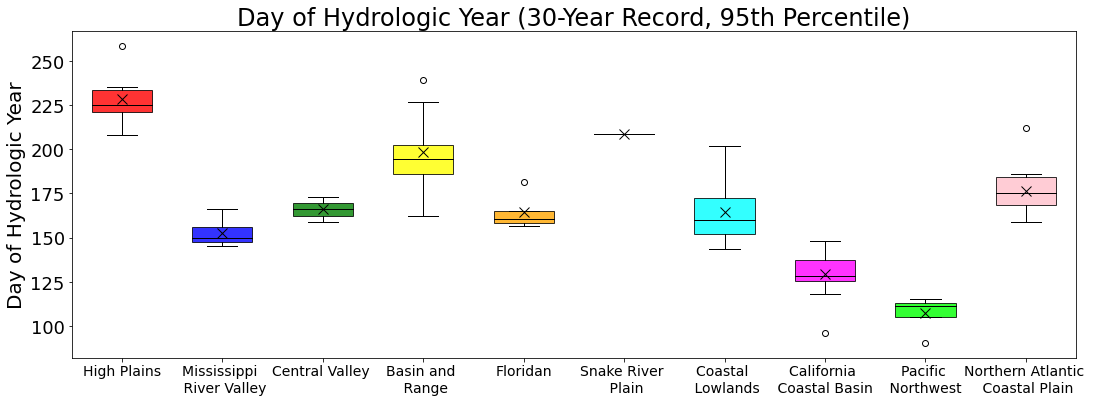

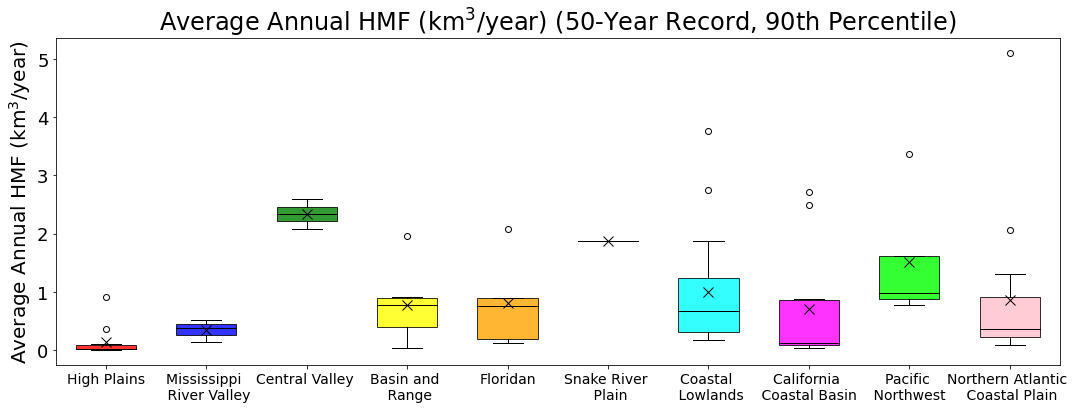

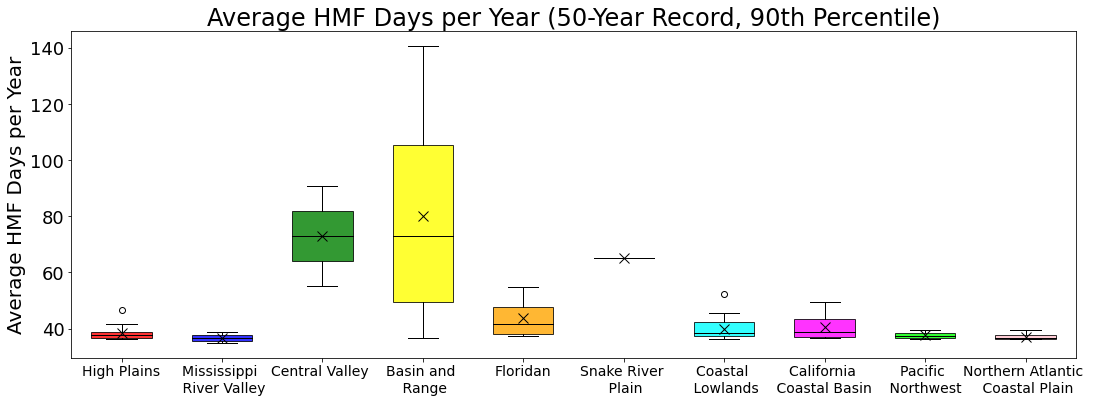

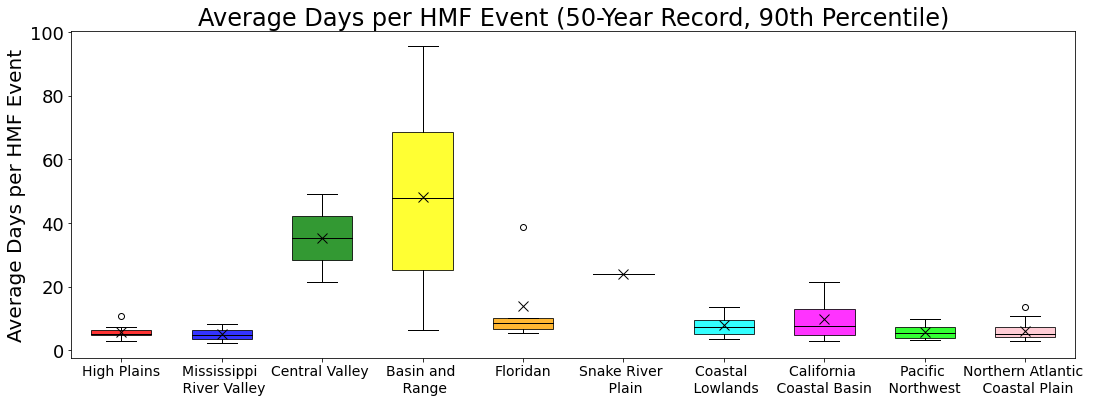

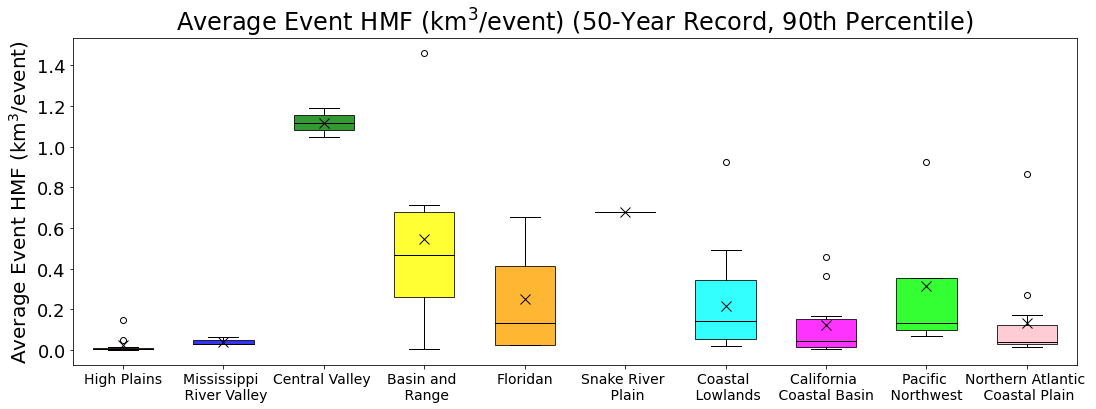

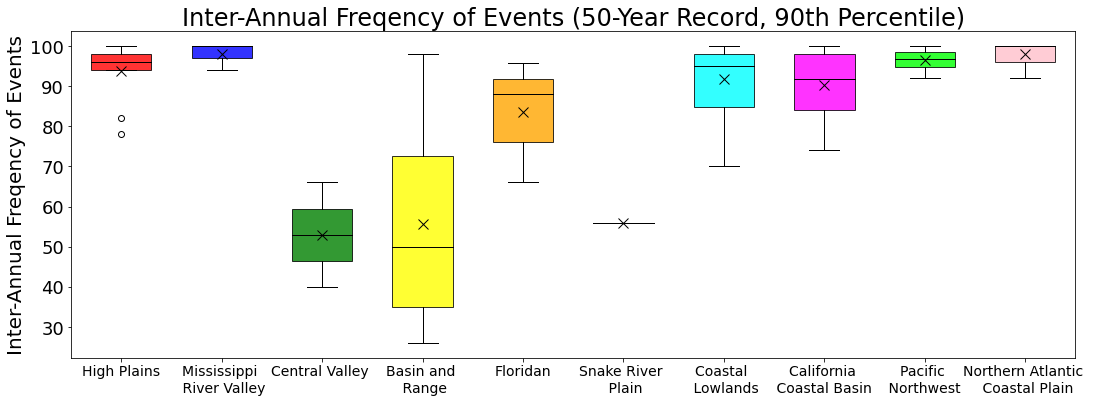

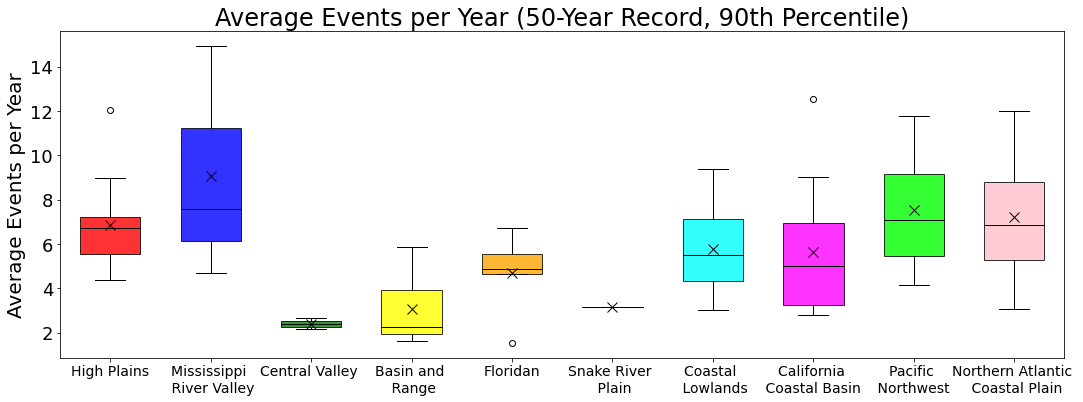

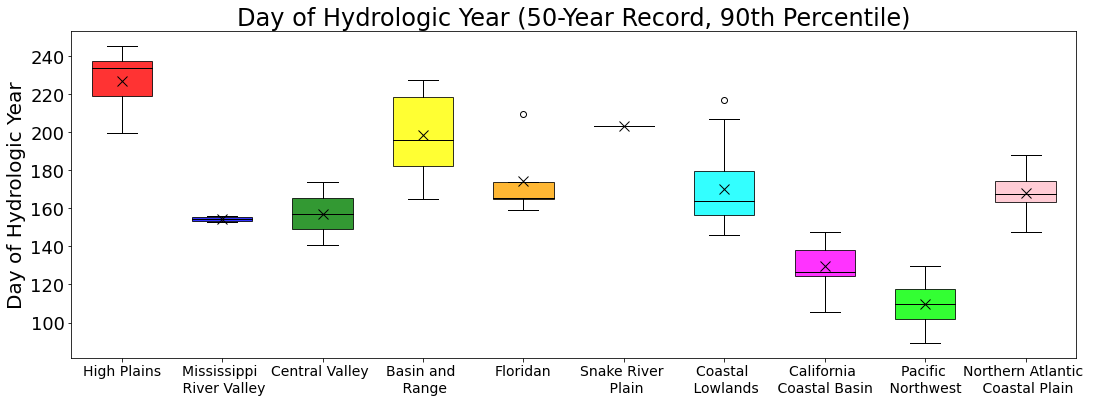

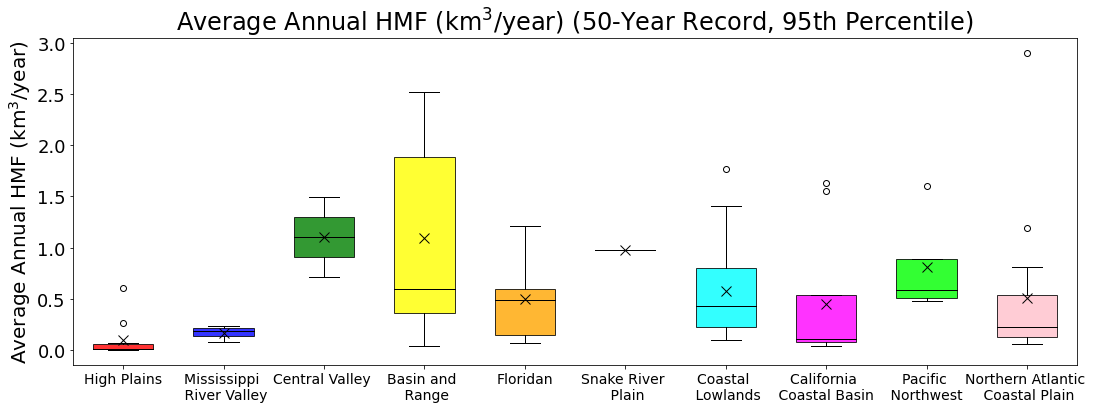

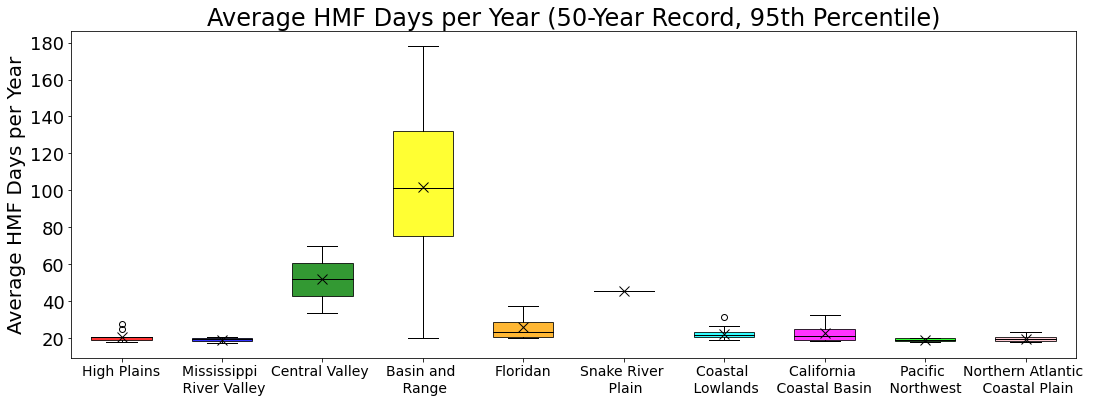

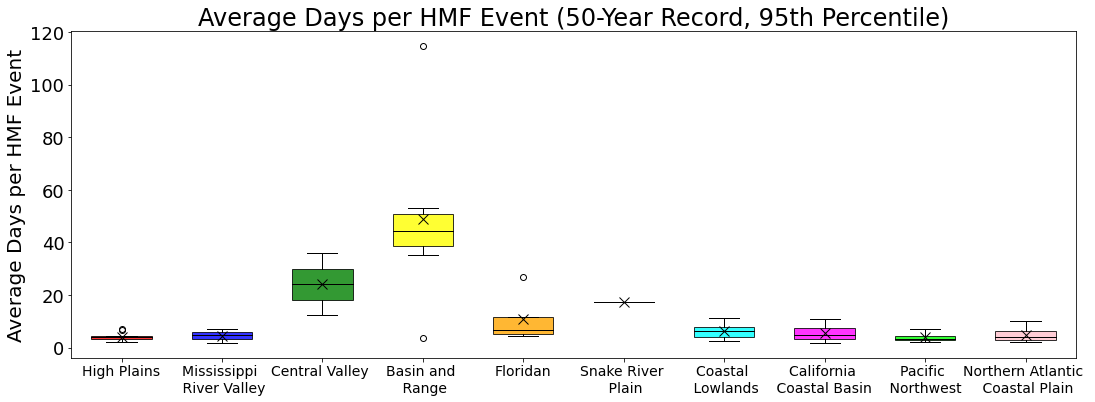

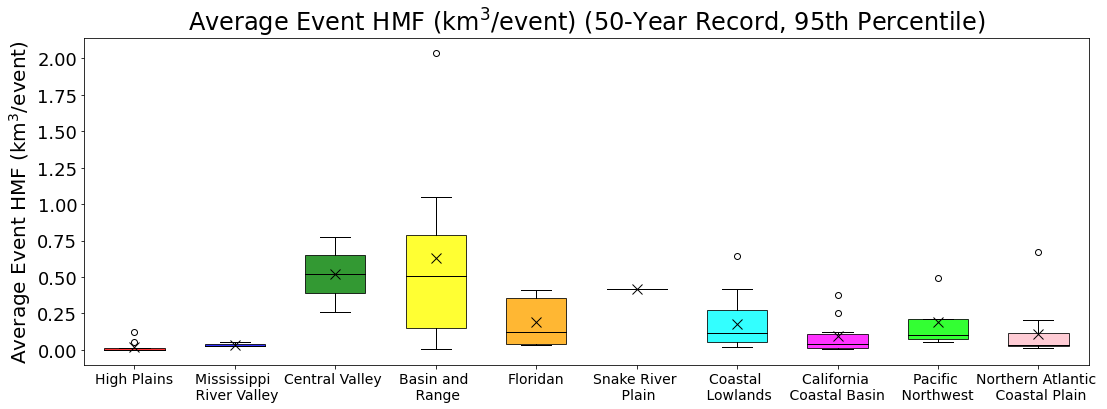

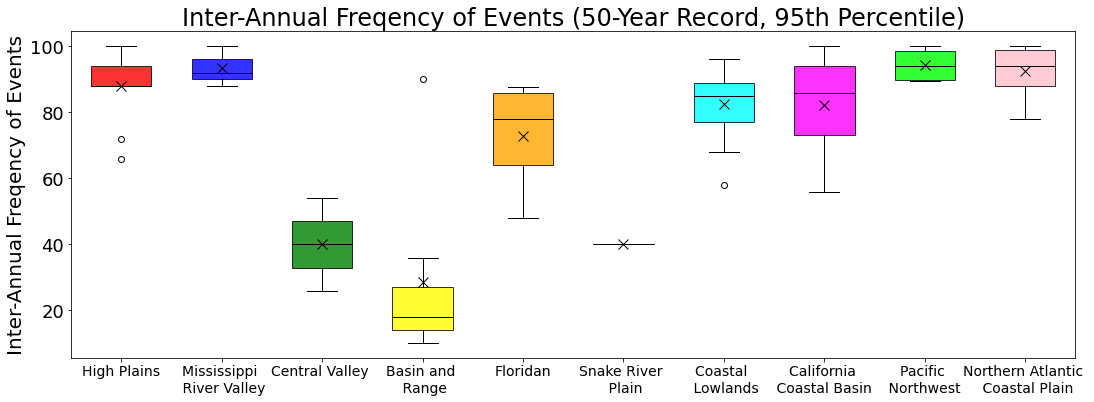

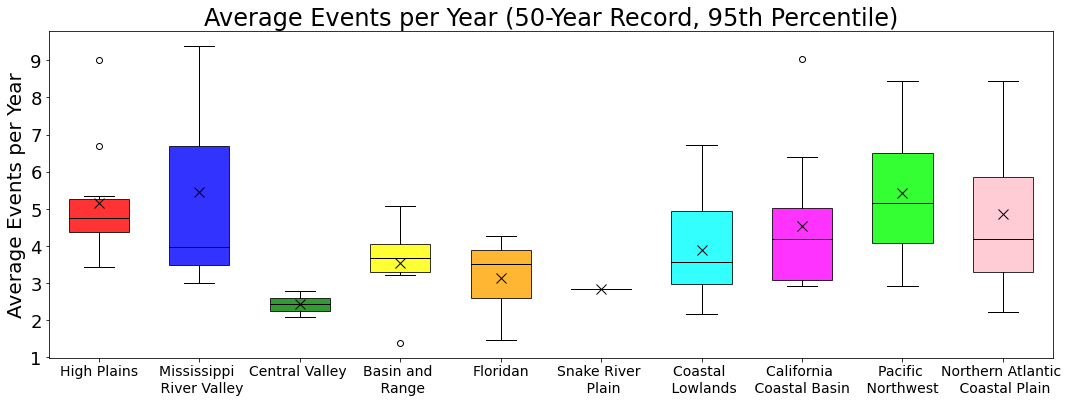

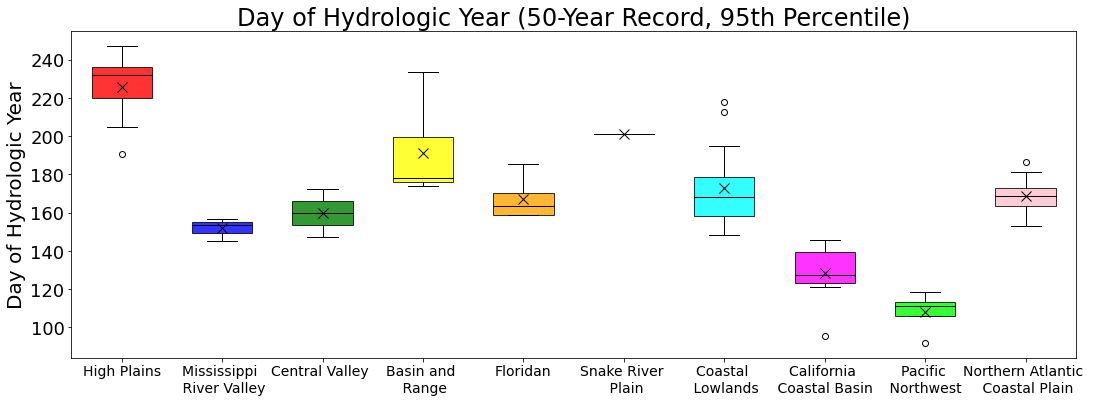

In [203]:
metric = 'timing'
metric_list = ['annual_hmf', 'annual_duration', 'event_duration',
               'event_hmf', 'inter_annual%', 'intra_annual', 'timing']
aq_codes = ['hp', 'mr', 'cv', 'br', 'fl', 'sr', 'cl', 'cc', 'pn', 'na']
aq_colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'cyan', 'magenta', 'lime', 'pink']
alpha_list = [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]
date_range = '30'
percentile = '90'

def outlet_gages_metrics_boxplot(metric, date_range, percentile):
    fig, ax = plt.subplots(figsize=(18, 6))
    # plt.boxplot([df_outlet_gages[f'{date_range}_{percentile}']['hp'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['mr'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['cv'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['br'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['fl'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['sr'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['cl'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['cc'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['pn'][metric],
    #              df_outlet_gages[f'{date_range}_{percentile}']['na'][metric]
    #             ])

    for j, aq_code in enumerate(aq_codes):
        ax.boxplot(df_outlet_gages[f'{date_range}_{percentile}'][aq_code][metric], positions=[j], widths=0.6, patch_artist=True,
                boxprops=dict(facecolor=aq_colors[j], alpha=alpha_list[j]), 
                medianprops=dict(color='#000000'),
                showmeans=True, meanprops={"marker":"x", "markeredgecolor":"black", "markersize":"10"})

    tick_labels = ['High Plains',
                    'Mississippi \n River Valley',
                    'Central Valley ',
                    'Basin and \n Range',
                    'Floridan',
                    'Snake River \n Plain',
                    'Coastal \n Lowlands',
                    'California \n Coastal Basin ', 
                    'Pacific \n Northwest ',
                    'Northern Atlantic \n Coastal Plain']

    plt.xticks([0,1,2,3,4,5,6,7,8,9], tick_labels, fontsize=14)
    plt.tick_params(axis='y', which='major', labelsize=18)
    plt.ylabel(f'{fn.FLOW_METRIC_UNITS[metric]}', fontsize=20)
    plt.title(f'{fn.FLOW_METRIC_UNITS[metric]} ({date_range}-Year Record, {percentile}th Percentile)', fontsize=24)

    plt.savefig(f'Saved_Visuals/Aquifers/HMF_metrics/boxplots_{metric}_{date_range}_{percentile}.png', bbox_inches='tight')

    plt.show()
    return
              
for date_range in date_ranges:
    for percentile in percentiles:
        for metric in metric_list:
              outlet_gages_metrics_boxplot(metric, date_range, percentile)

### Sort by HUC2

In [148]:
df_temp = dfs_valid['30_90']
huc2_codes = dfs_valid['30_90']['huc2_code_x'].unique().tolist()
#huc2_codes
dict_huc2 = {}
for huc2_code in huc2_codes:
    dict_huc2[huc2_code] = df_temp[df_temp['huc2_code_x'] == huc2_code]['site_no'].unique().tolist()
#dict_huc2 

In [150]:
df_huc2_gages = {}
for date_range in date_ranges:
    for percentile in percentiles: 
        df_huc2_huc = {}
        df_temp = dfs_valid[f'{date_range}_{percentile}']

        for key, value in dict_huc2.items():
            df_huc2_huc[key] = df_temp[df_temp['site_no'].isin(value)]
       
        df_huc2_gages[f'{date_range}_{percentile}'] = df_huc2_huc

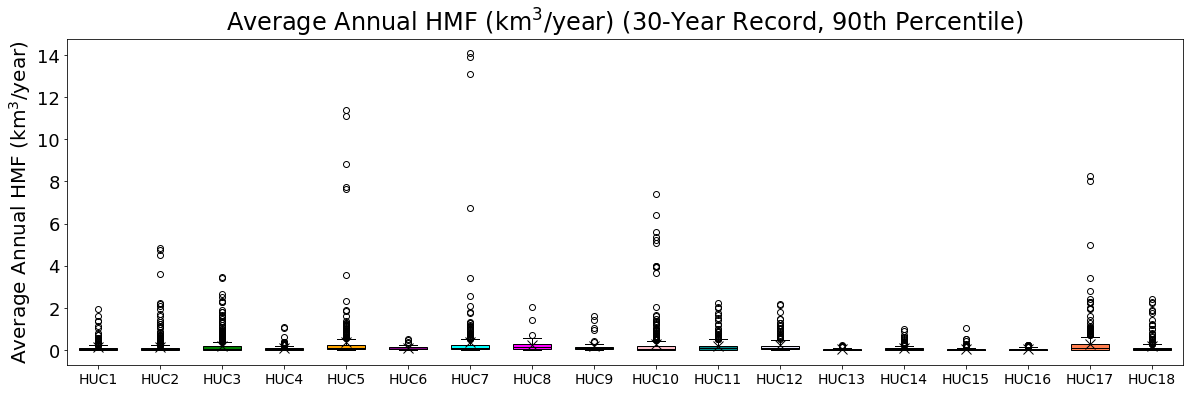

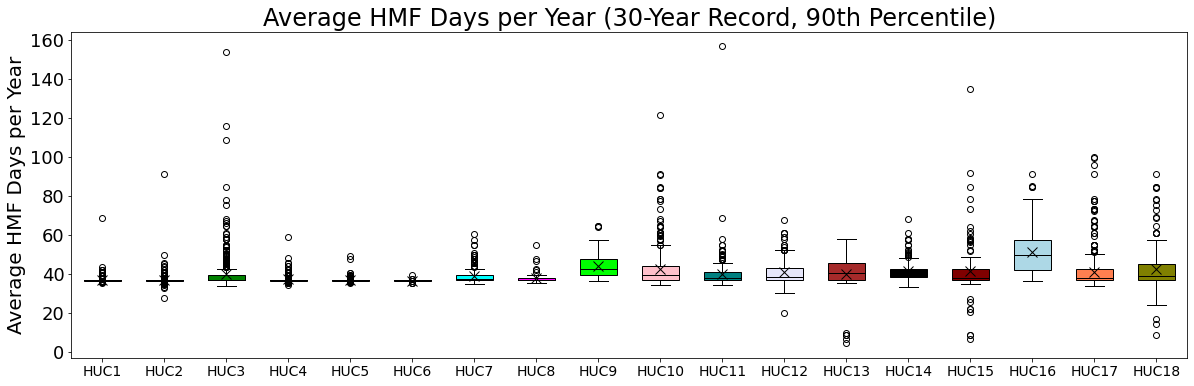

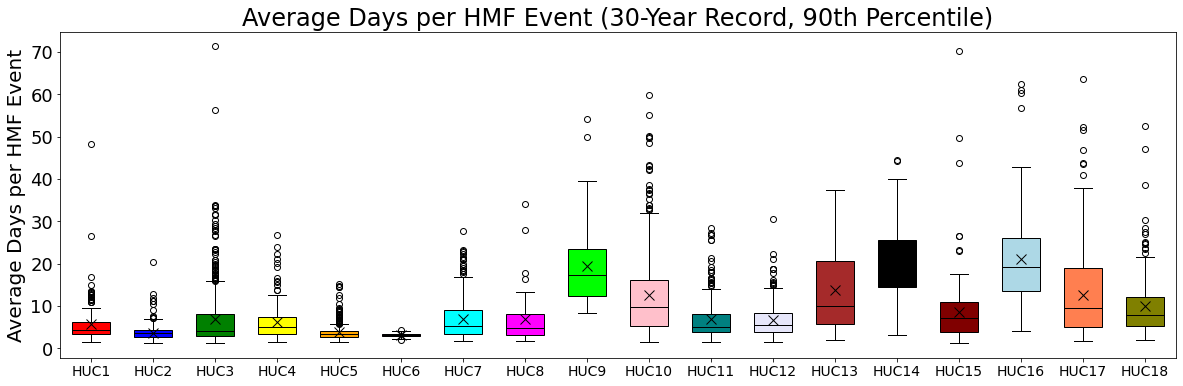

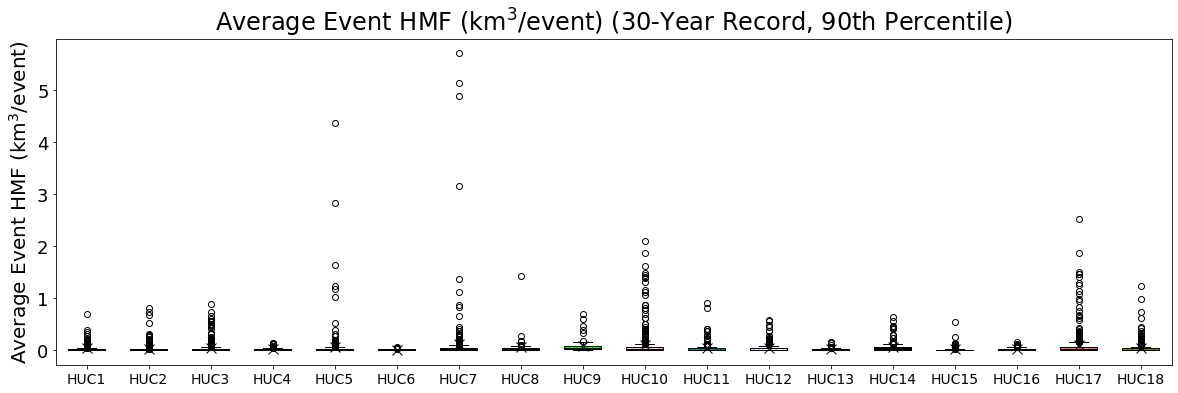

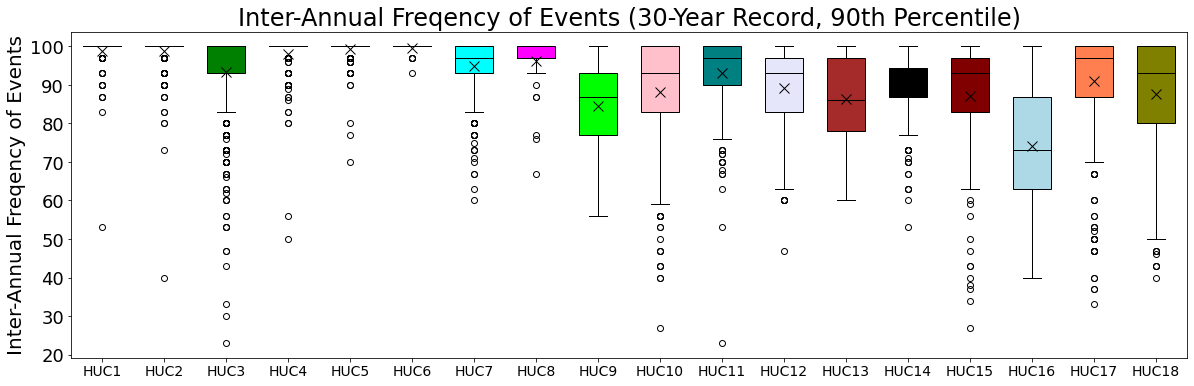

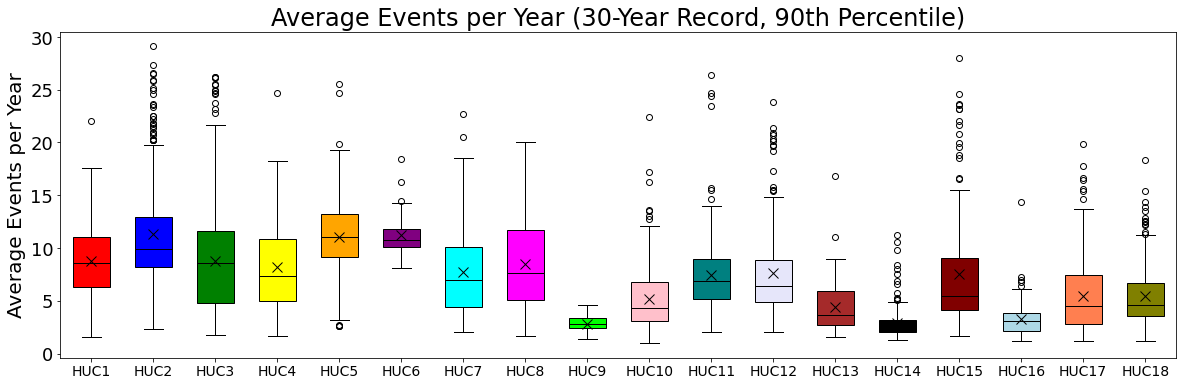

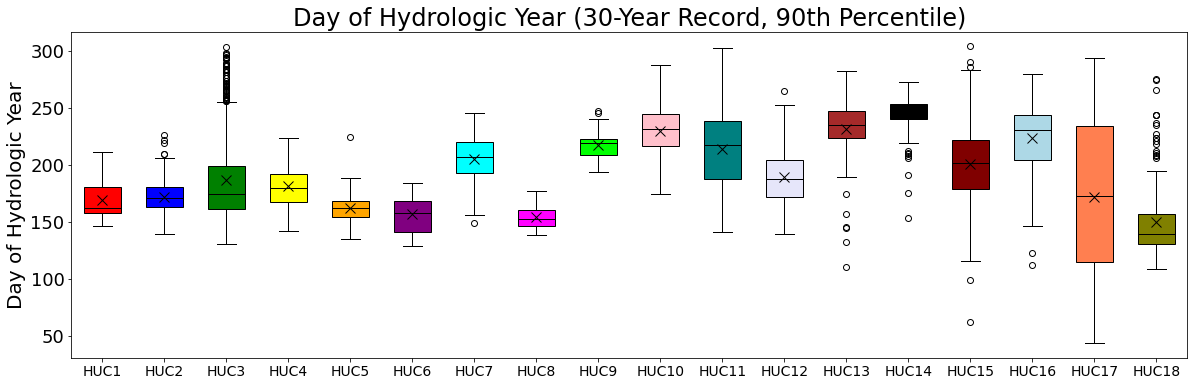

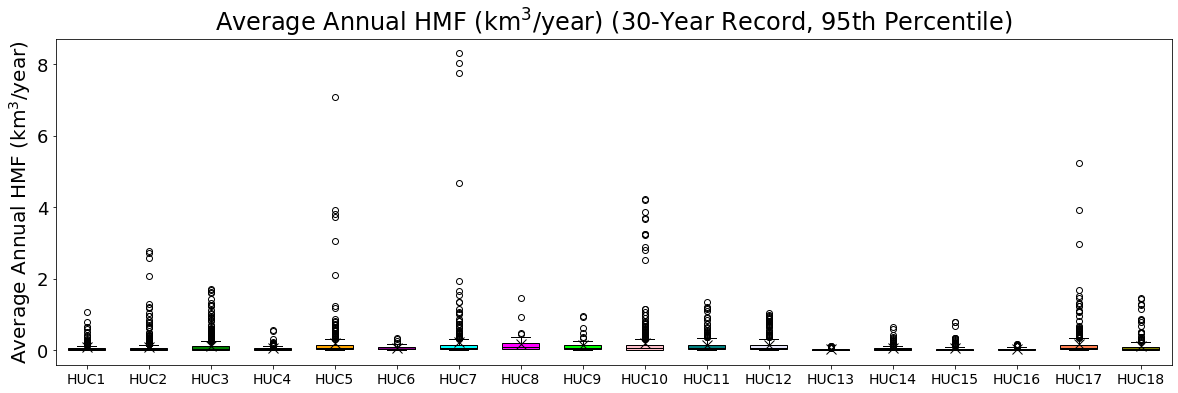

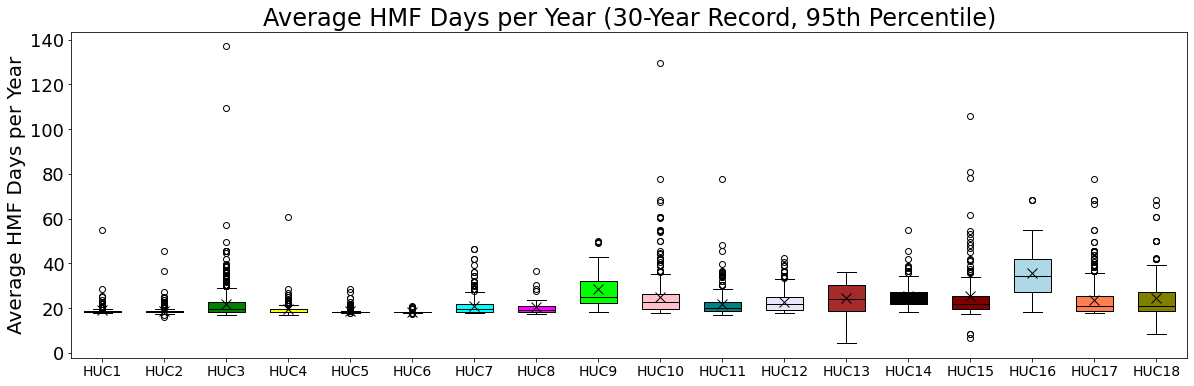

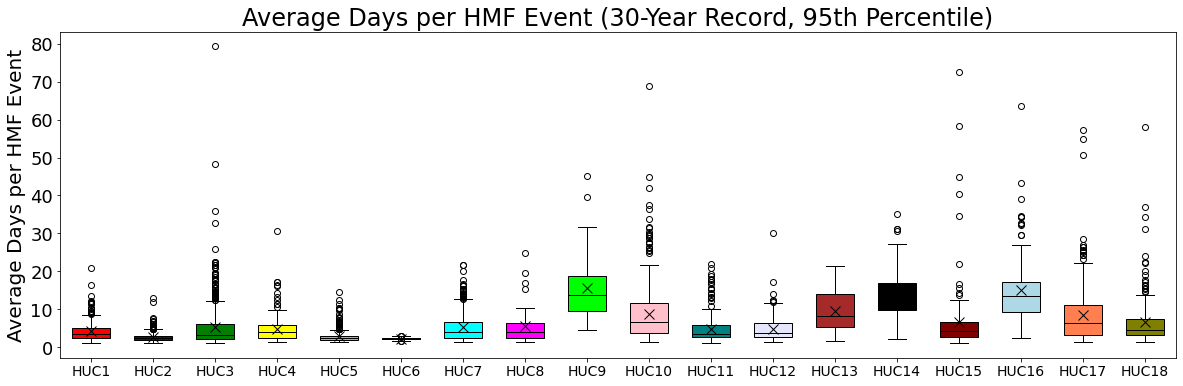

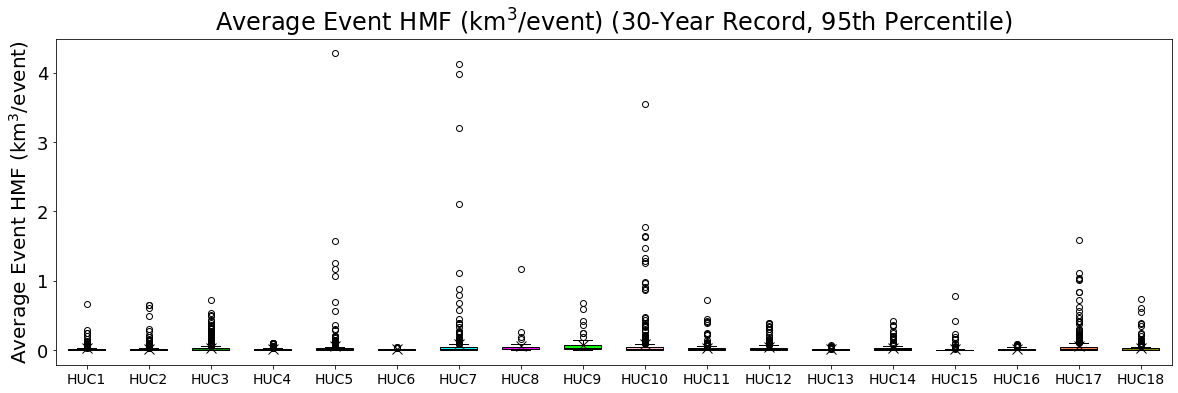

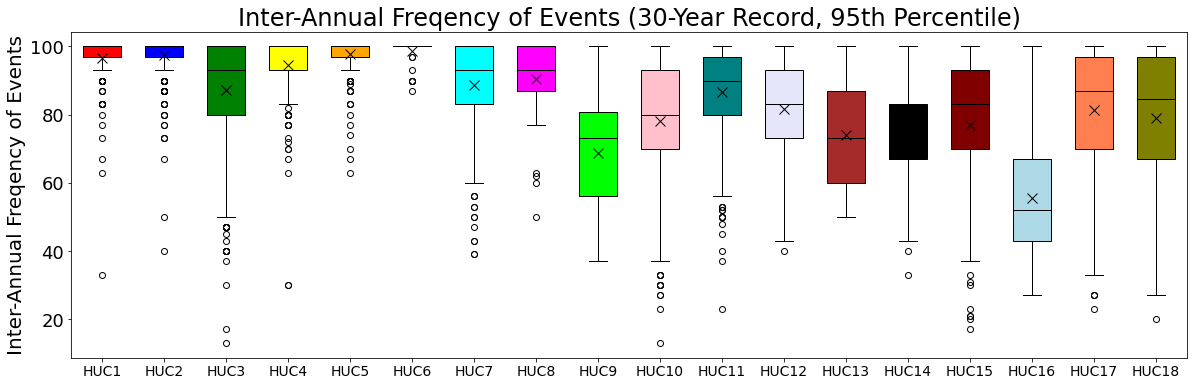

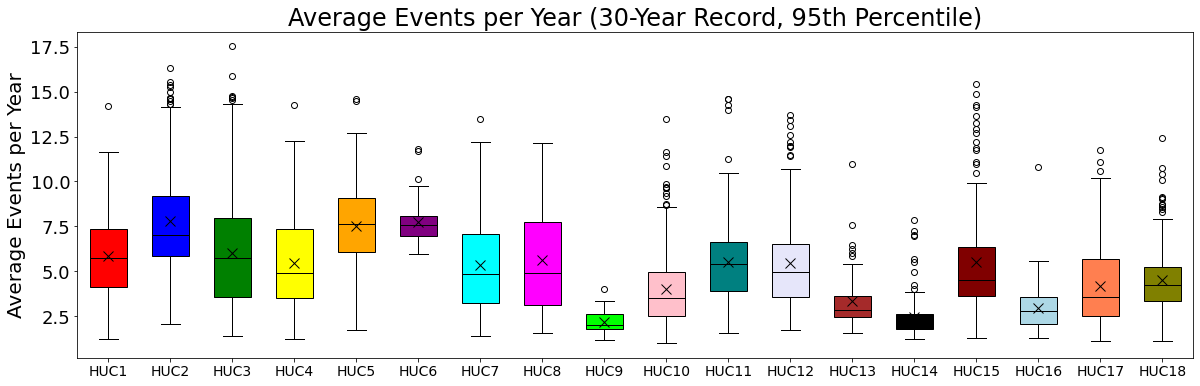

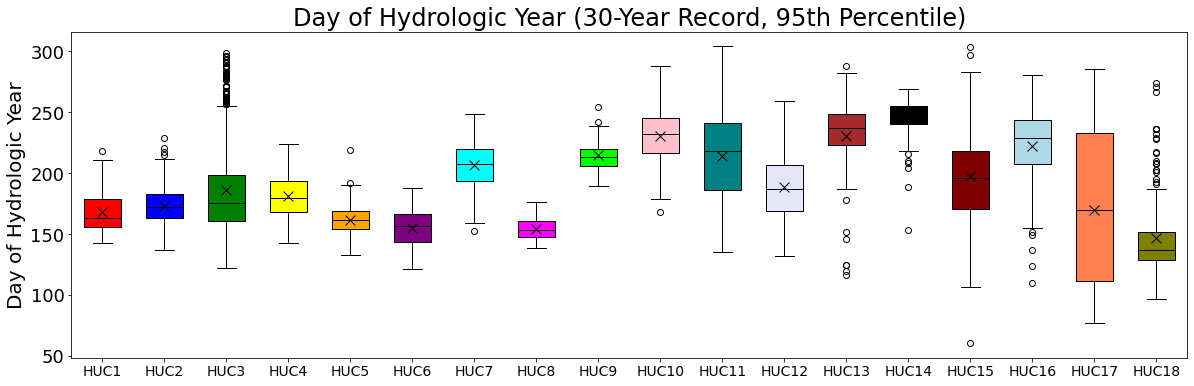

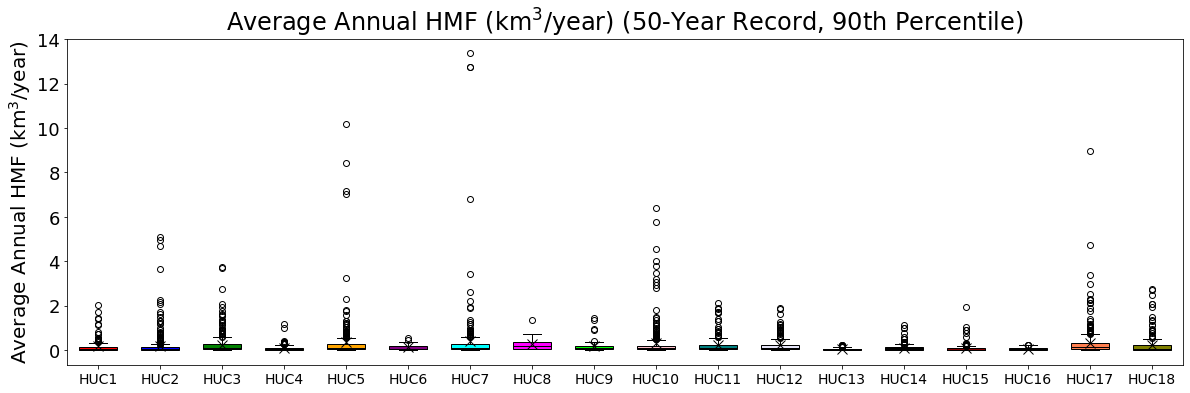

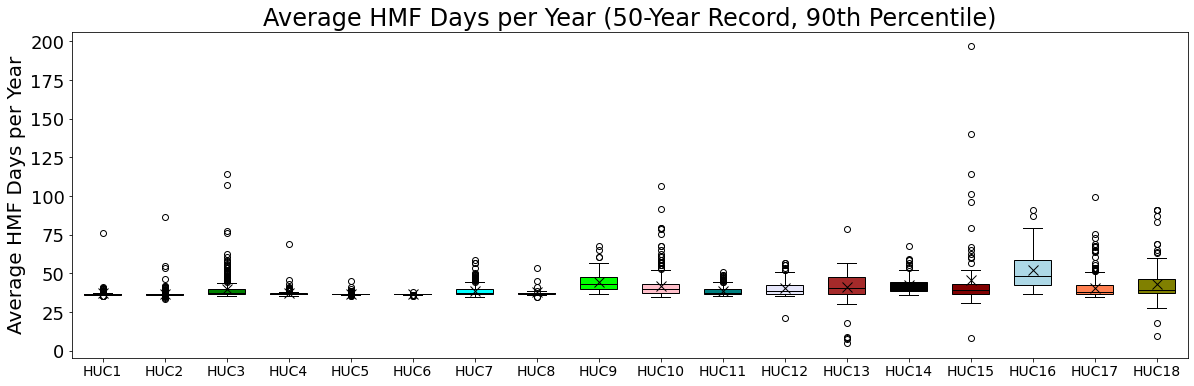

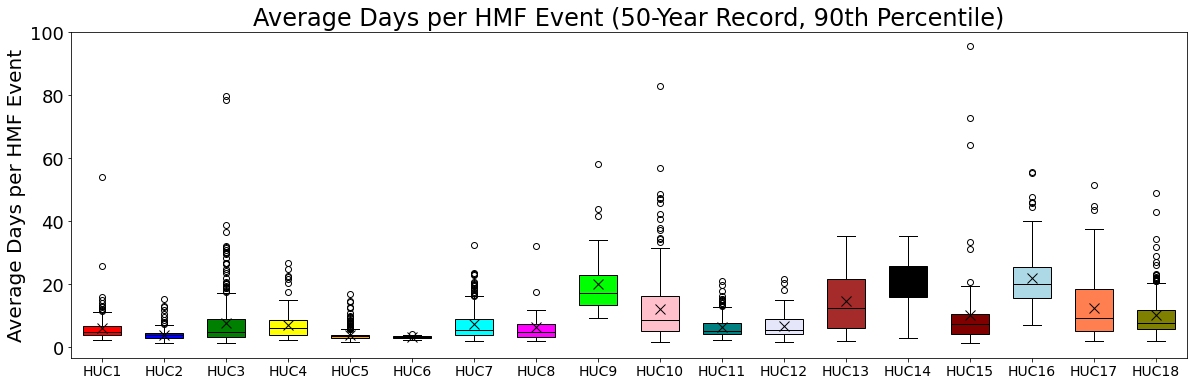

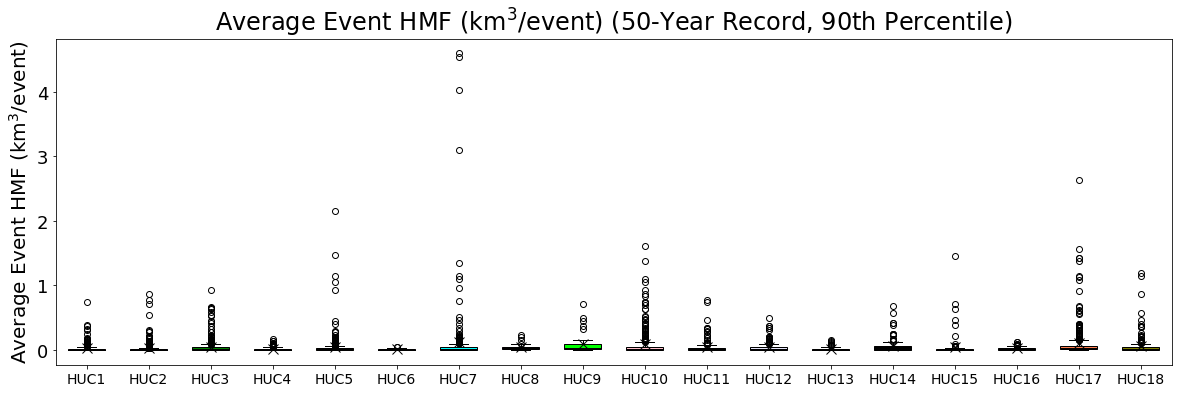

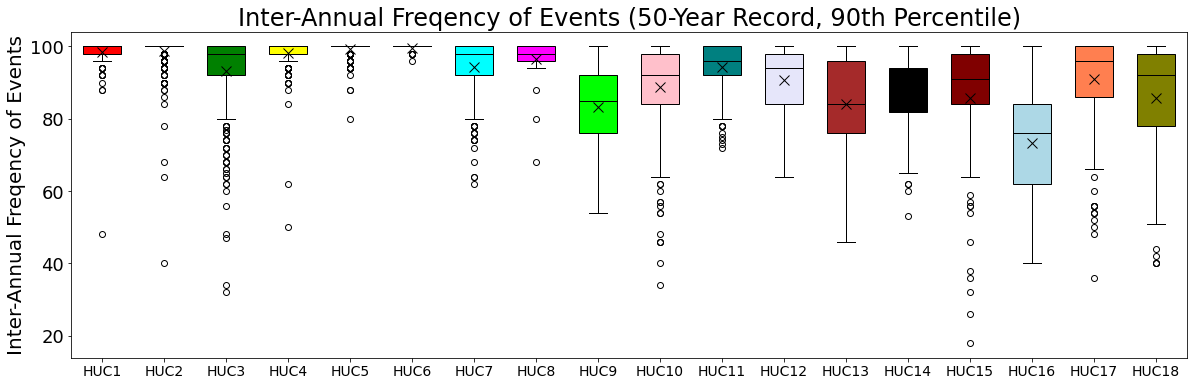

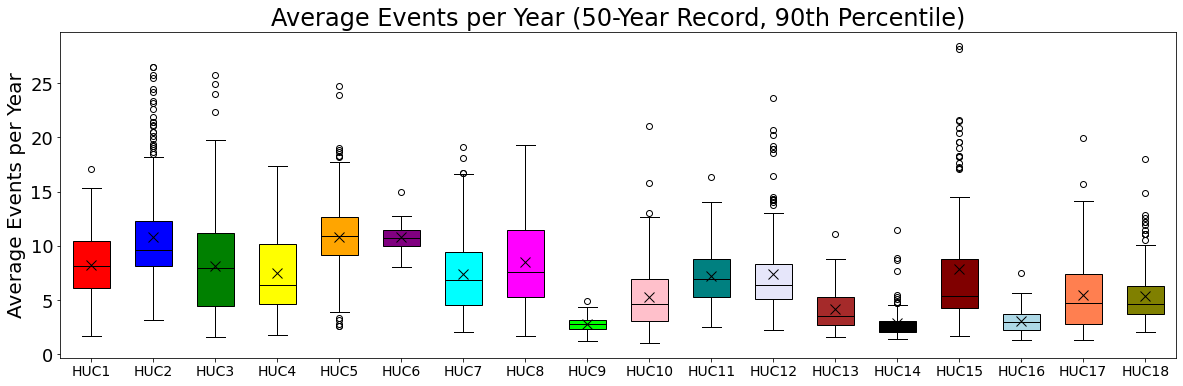

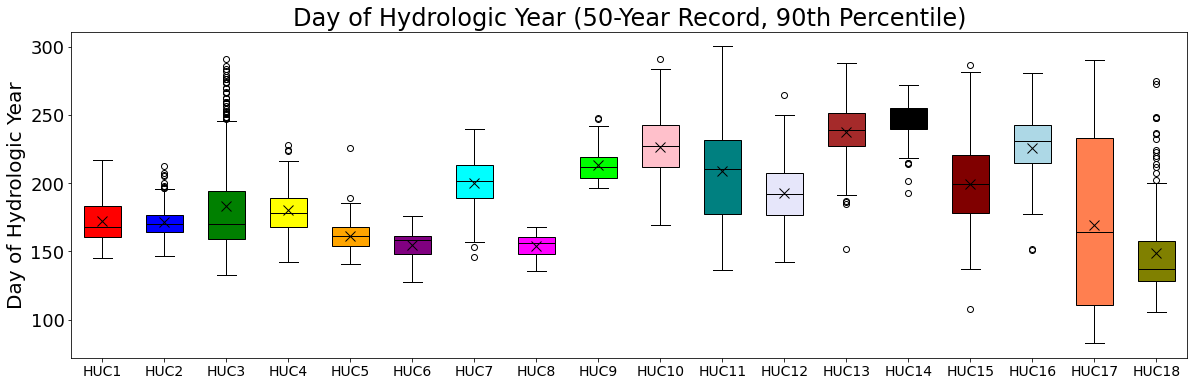

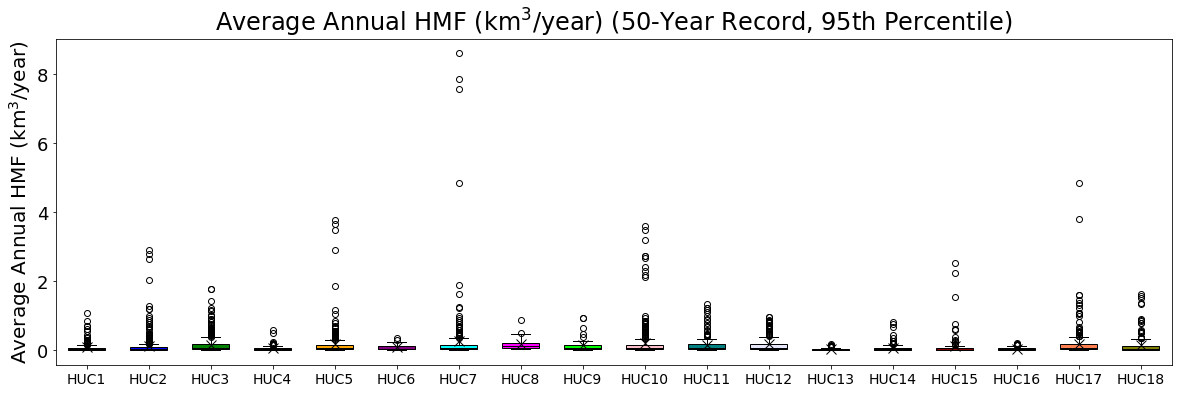

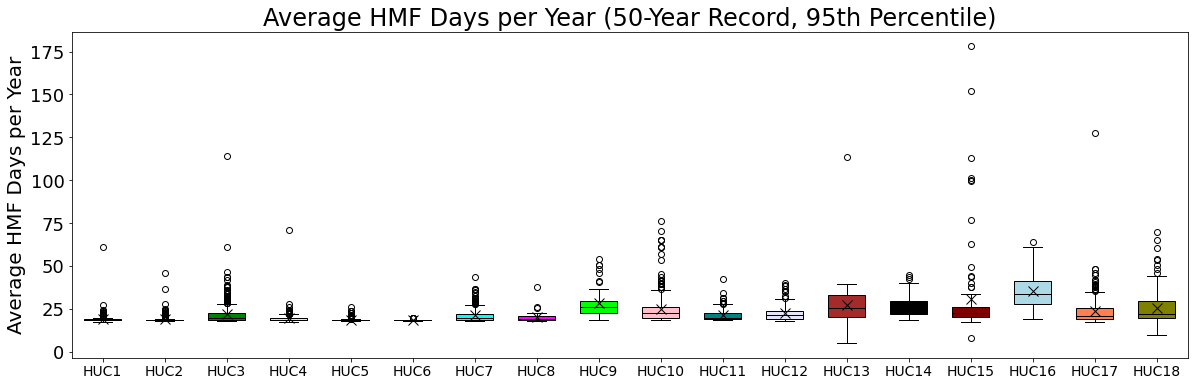

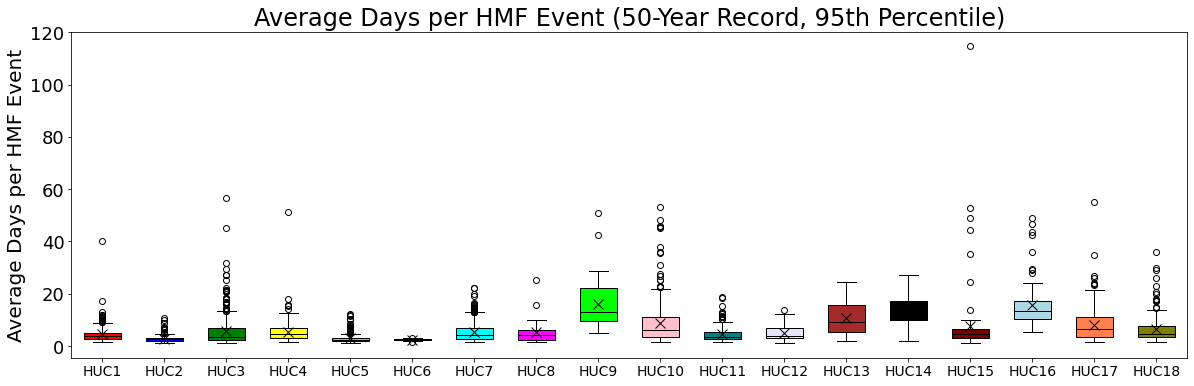

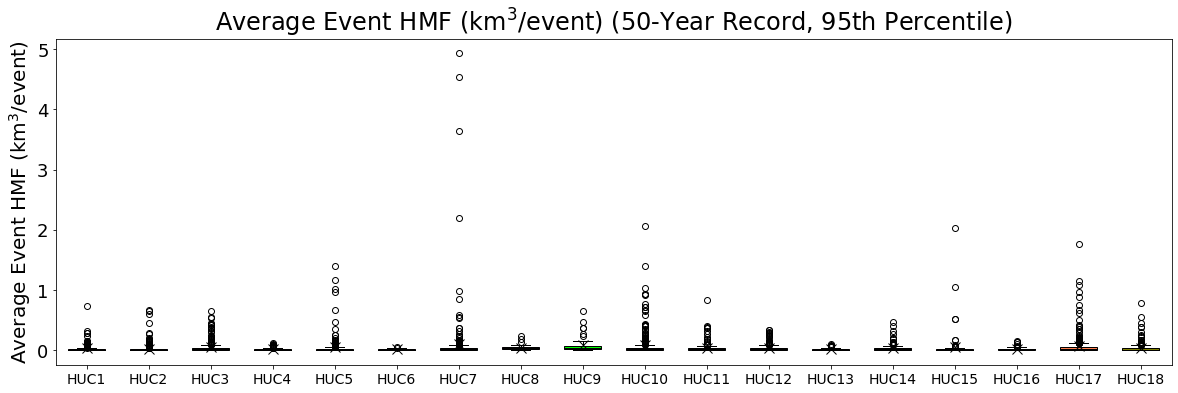

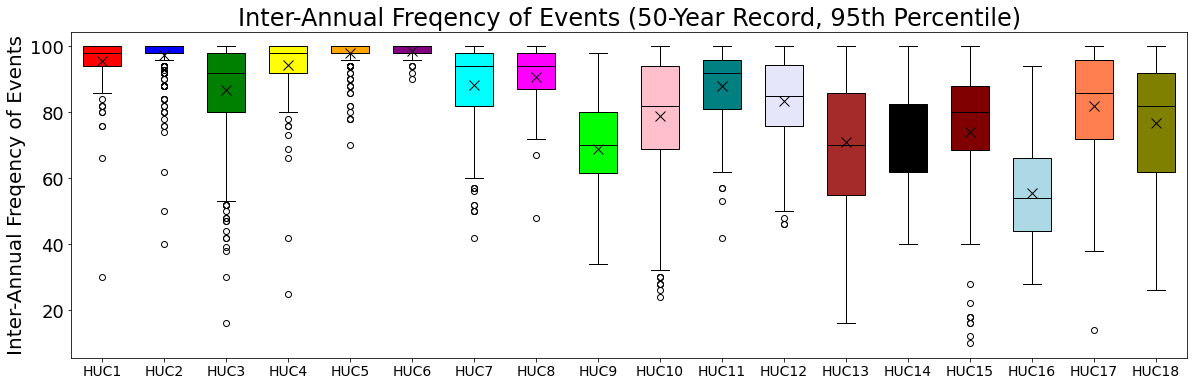

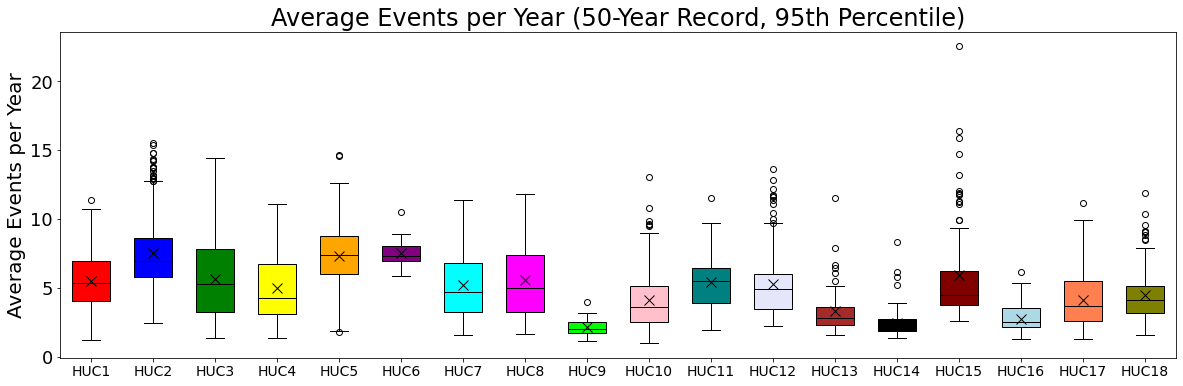

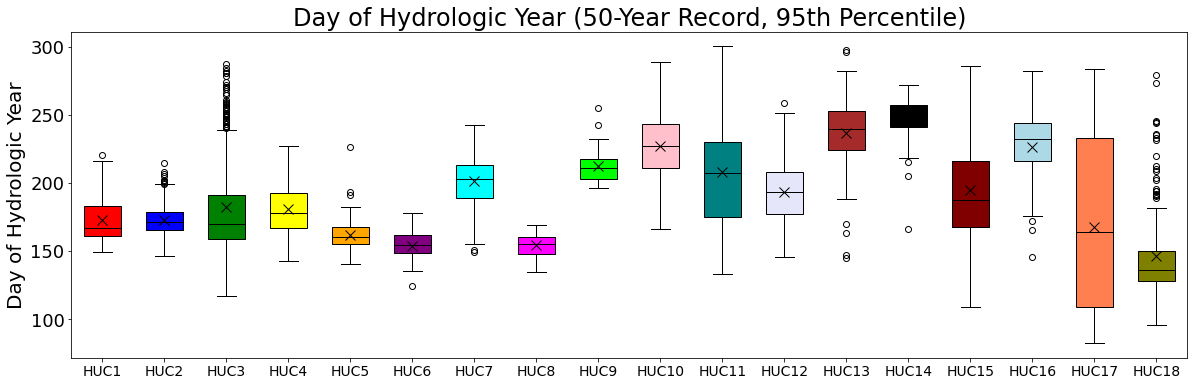

In [212]:
huc2_codes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'cyan', 'magenta', 'lime', 'pink',
               'teal', 'lavender', 'brown', 'black', 'maroon', 'lightblue', 'coral', 'olive']
metric_list = ['annual_hmf', 'annual_duration', 'event_duration',
               'event_hmf', 'inter_annual%', 'intra_annual', 'timing']

def huc2_gages_metrics_boxplot(metric, date_range, percentile):
    fig, ax = plt.subplots(figsize=(20, 6))
    # plt.boxplot([df_huc2_gages[f'{date_range}_{percentile}'][1][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][2][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][3][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][4][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][5][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][6][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][7][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][8][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][9][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][10][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][11][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][12][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][13][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][14][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][15][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][16][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][17][metric],
    #              df_huc2_gages[f'{date_range}_{percentile}'][18][metric]
    #             ])

    for j, code in enumerate(huc2_codes):
        ax.boxplot(df_huc2_gages[f'{date_range}_{percentile}'][code][metric], positions=[j], widths=0.6, patch_artist=True,
                boxprops=dict(facecolor=colors[j]), #alpha=alpha_list[j]), 
                medianprops=dict(color='#000000'),
                showmeans=True, meanprops={"marker":"x", "markeredgecolor":"black", "markersize":"10"})

    tick_labels = ['HUC1', 'HUC2', 'HUC3', 'HUC4', 'HUC5', 'HUC6', 'HUC7', 'HUC8', 'HUC9',
                   'HUC10', 'HUC11', 'HUC12', 'HUC13', 'HUC14', 'HUC15', 'HUC16', 'HUC17', 'HUC18']

    plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17], tick_labels, fontsize=14)
    plt.tick_params(axis='y', which='major', labelsize=18)
    plt.ylabel(f'{fn.FLOW_METRIC_UNITS[metric]}', fontsize=20)
    plt.title(f'{fn.FLOW_METRIC_UNITS[metric]} ({date_range}-Year Record, {percentile}th Percentile)', fontsize=24)

    plt.savefig(f'Saved_Visuals/HUC2/HMF_metrics/boxplots_{metric}_{date_range}_{percentile}.png', bbox_inches='tight')

    plt.show()
    return

for date_range in date_ranges:
    for percentile in percentiles:
        for metric in metric_list:
              huc2_gages_metrics_boxplot(metric, date_range, percentile)

## Event frequency duration curve

In [240]:
def sort_events(df):
    df_sort_dur = df.sort_values('duration')
    #df_sort_mean = df_sort_dur.groupby('duration').mean()
    df_sort = df_sort_dur.groupby('duration')['hmf'].agg(['mean', 'size']).reset_index()
    df_sort = df_sort.rename(columns={'size':'count'})
    df_sort = df_sort.rename(columns={'mean':'hmf'})  
    return df_sort

By aquifer

In [221]:
df_results = pd.DataFrame()

# This is a cut down version of single_site_analysis() focused only on event metrics
def events_subdf(site):
    #if i == test_limit: break
    date_range = 30
    quantile = 90
    df = nwis.get_record(sites=site, service=fn.SERVICE, parameterCD=[fn.PARAM_CODE, fn.TIDAL_CODE], start=fn.DEFAULT_START, end=fn.DEFAULT_END)
    df = df.reset_index()

    # Only run on valid sites so this should never be the case but check anyways
    #if df.empty: continue

    if '00060_radar sensor_Mean' in df.columns and '00060_Mean' not in df.columns:
        df.rename(columns={'00060_radar sensor_Mean': '00060_Mean'}, inplace=True)

    df = fn.merge_tidal(df)

    # Cropping to date range
    date_threshold = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * date_range)
    df = df[df['datetime'].dt.date >= date_threshold]

    threshold = fn.calc_threshold(df, (quantile / 100))
    _, hmf_series_cont = fn.filter_hmf(df, threshold)
    hmf_series_cont = fn.convert_hmf(hmf_series_cont, threshold)

    hmf_series_cont['00060_Mean'] = hmf_series_cont['00060_Mean'] * fn.CUBIC_FT_KM_FACTOR
    hmf_series_cont.to_csv('hmf_series_cont.csv')

    # Insert a dummy row at the end to ensure the last event is captured
    last = hmf_series_cont['datetime'].iloc[-1] + timedelta(days=1)
    insert = {'datetime': last, '00060_Mean': 0, 'site_no': site}
    hmf_series_cont = pd.concat([hmf_series_cont, pd.DataFrame(insert, index=[0])]).reset_index(drop=True)

    event_count = hmf = duration = 0
    event = False
    start = end = None
    df_results = pd.DataFrame()
    for i, row in hmf_series_cont.iterrows():     

        # No current event and none starting now
        if row['00060_Mean'] == 0 and event == False:
            event = False
            continue

        # New event starting
        if row['00060_Mean'] > 0 and event == False:
            hmf = row['00060_Mean']
            start = row['datetime'].date()
            duration = 1
            event_count += 1
            event = True
            continue

        # Current event continuing
        if row['00060_Mean'] > 0 and event == True:
            hmf += row['00060_Mean']
            duration += 1
            event = True
            continue

        # Current event ending, add to dataframe
        if row['00060_Mean'] == 0 and event == True:
            end = row['datetime'].date() - timedelta(days=1)
            data = {'site_no': site, 'event': event_count, 'start': start, 'end': end, 'hmf': hmf, 'duration': duration}
            df_results = pd.concat([df_results, pd.DataFrame(data, index=[0])])
            event = False
            continue

    df_results = df_results.reset_index(drop=True) 
    return df_results
    #df_results.to_csv(f'events_subdf.csv')

In [242]:
aq_codes = ['hp', 'mr', 'cv', 'br', 'fl', 'sr', 'cl', 'cc', 'pn', 'na']
events_by_aq_dict = {}
for aq in aq_codes:
    gages = outlet_gages_dict[aq]
    print(gages)
    events_by_gage_dict = {}
    for gage in gages:
        events_by_gage_dict[gage] = events_subdf(gage)
    events_by_aq_dict[aq] = events_by_gage_dict

['08123800', '08121000', '07297910', '07228000', '07234000', '07157500', '07144550', '06853500', '06805500', '06799500', '06465500']
['07077000', '07077555', '07047942', '07369000', '07369000', '07285500', '07268000']
['11303500', '11447650']
['09520500', '09429600', '09521100', '09519800', '09468500', '09423000', '10327500', '10351650', '10351650', '10311400']
['02368000', '02365500', '02358000', '02320500', '02313230']
['13269000']
['08211000', '08188500', '08176500', '08164000', '08162000', '08116650', '08066500', '08033500', '08068000', '08030500', '08013500', '08012000', '07378500', '02492000', '02489500', '02479000', '02479300', '02469761', '02428400', '02375500']
['11023000', '11046000', '11078000', '11087020', '11133000', '11140000', '11152500', '11159000', '11467000', '11477000', '11530500', '11532500']
['11039800', '12200500', '12040500', '14211720', '14372300']
['02105769', '02089500', '02091500', '02083500', '02085000', '02052000', '02047000', '02049500', '02041650', '02037

In [226]:
combined_events_by_aq_dict = {}
for aq in aq_codes:
    aq_dict = events_by_aq_dict[aq]
    df_events_gages = pd.DataFrame()
    for site in aq_dict.keys():
        df = aq_dict[site]
        df_events_gages_sort = sort_events(df)
        df_events_gages = df_events_gages.append(df_events_gages_sort)
    combined_events_by_aq_dict[aq] = df_events_gages

In [237]:
aq_list_10 = ['High Plains aquifer',
                'Mississippi River Valley alluvial aquifer',
                'Central Valley aquifer system',
                'Basin and Range basin-fill aquifers',
                'Floridan aquifer system',
                'Snake River Plain basaltic-rock aquifers',
                'Coastal lowlands aquifer system',
                'California Coastal Basin aquifers', 
                'Pacific Northwest basin-fill aquifers',
                'Northern Atlantic Coastal Plain aquifer system']

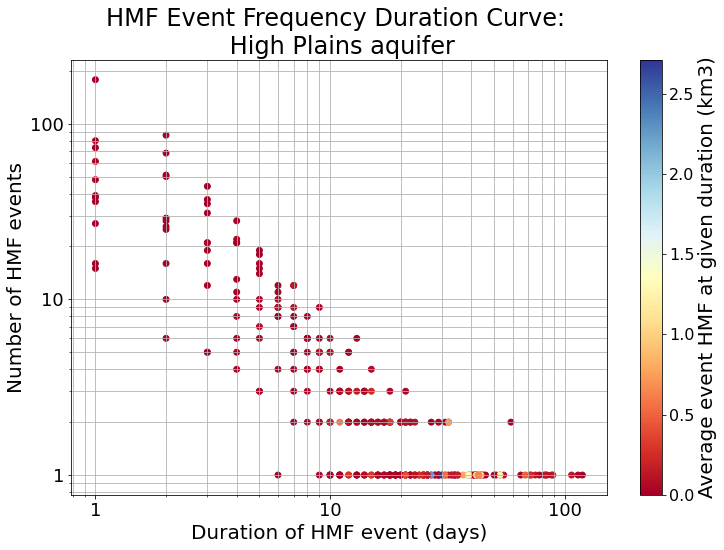

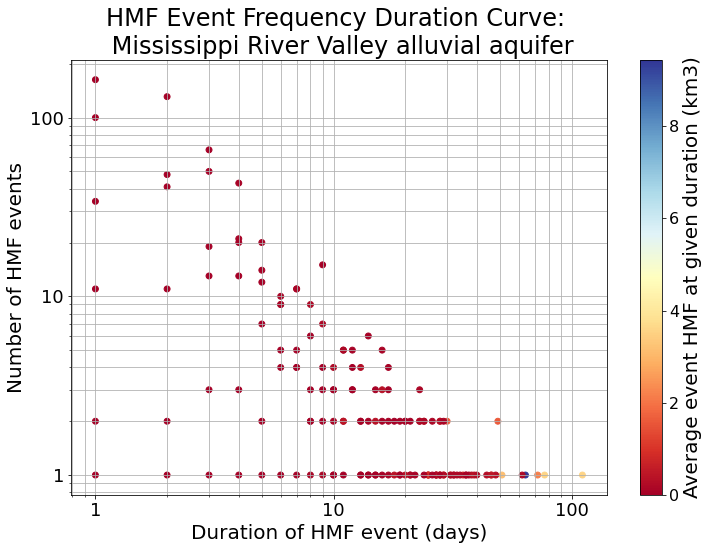

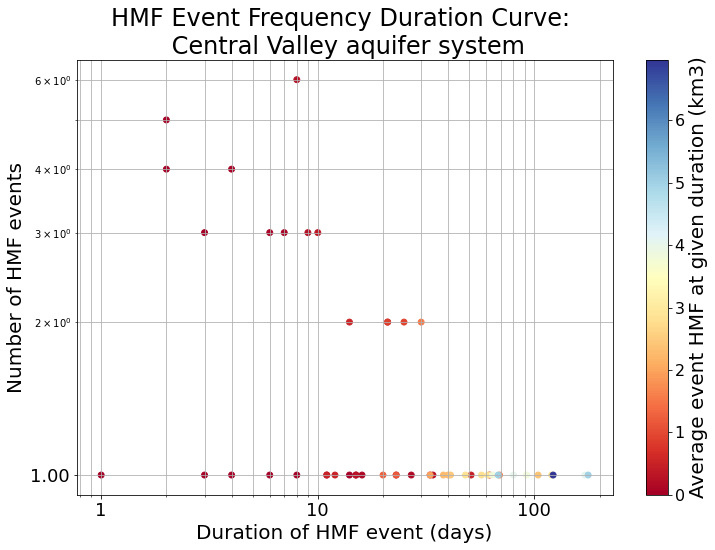

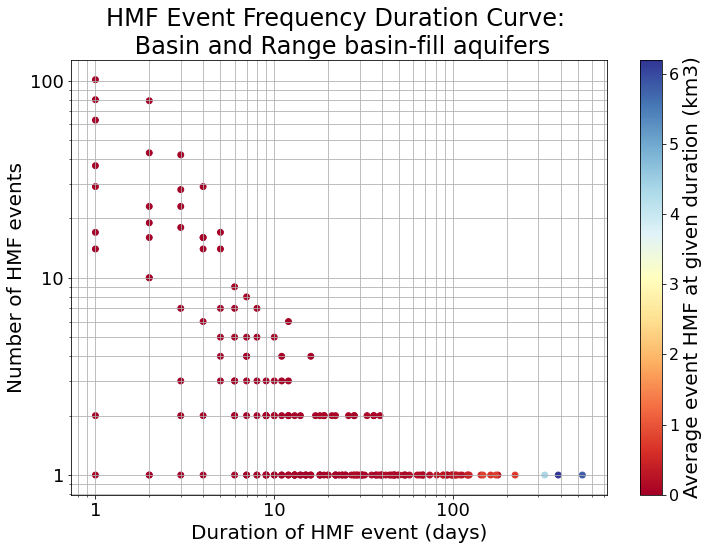

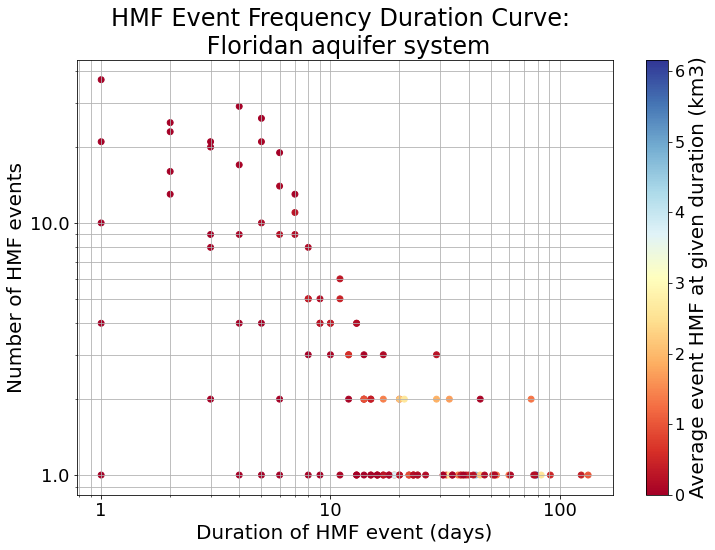

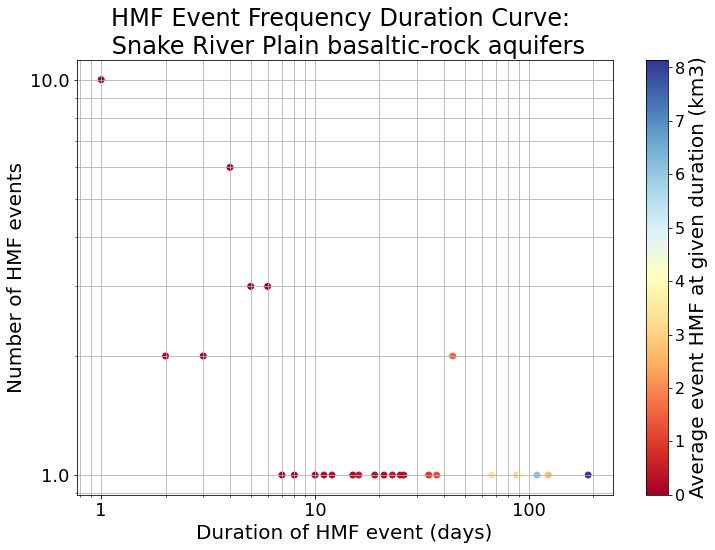

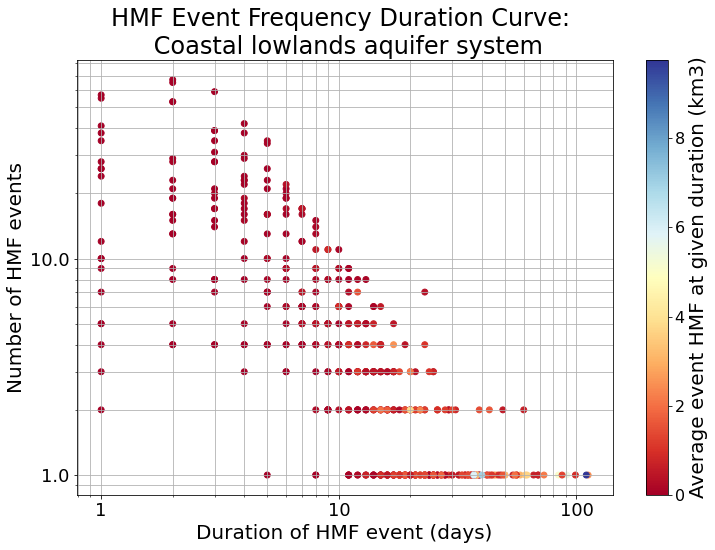

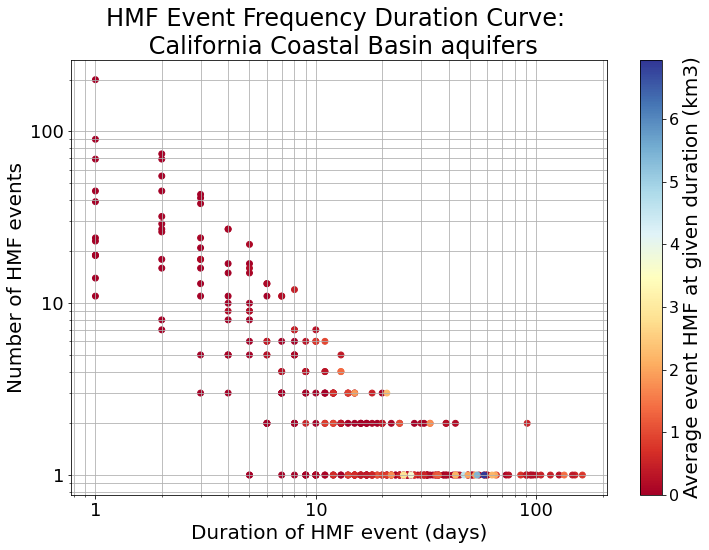

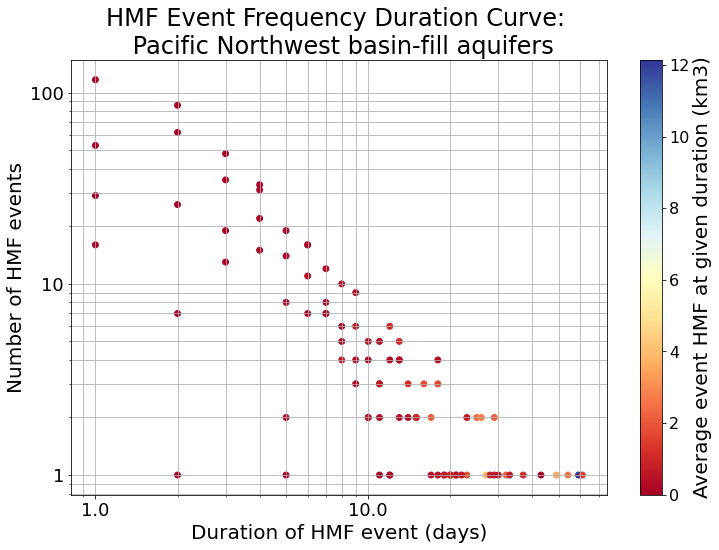

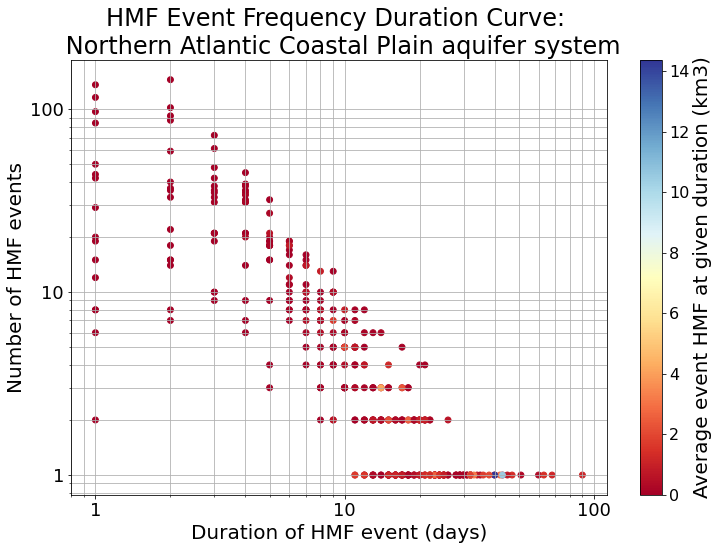

In [250]:
import matplotlib.ticker as mticker

def fdc_events(df, i):
    df_plot = df

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

    cm = plt.cm.get_cmap('RdYlBu')
    scatter = ax.scatter(df_plot['duration'], df_plot['count'], c=df_plot['hmf'], vmin=0, vmax=df_plot['hmf'].max(), s=35, cmap=cm)

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Average event HMF at given duration (km3)', fontsize=20)
    cbar.ax.tick_params(labelsize=16)

    ax.set_xlabel('Duration of HMF event (days)', fontsize=20)
    ax.set_ylabel('Number of HMF events', fontsize=20)
    ax.set_title(f'HMF Event Frequency Duration Curve: \n {aq_list_10[i]}', fontsize=24)

    plt.xscale("log")
    plt.yscale("log")

    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.xaxis.get_major_formatter().set_scientific(False)
    ax.xaxis.get_major_formatter().set_useOffset(False)
    ax.yaxis.get_major_formatter().set_scientific(False)
    ax.yaxis.get_major_formatter().set_useOffset(False)
    #ax.mticker.FormatStrFormatter('%d')

    plt.grid('True', which="both", ls="-")
    
    plt.tick_params(axis='both', which='major', labelsize=18)

    img_path = f'Saved_Visuals/Aquifers/fre_dur_curve/fdc_{aq}.png'
    fn.save_plot_as_image(img_path, overwrite=True) 

    plt.show()
    
for i, aq in enumerate(aq_codes):
    df = combined_events_by_aq_dict[aq]
    fdc_events(df, i)